# Importing packages

## QCoDeS and equipment drivers

In [1]:
%matplotlib notebook

import os
import sys 
import time
import datetime

from collections import OrderedDict
from importlib import reload

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

from IPython.display import clear_output
from IPython.display import Image

import qcodes as qc
from qcodes.dataset.database import initialise_database, get_DB_location
from qcodes import new_experiment, Station, Instrument
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import load_by_id
from qcodes.dataset.data_export import get_data_by_id

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
from qcodes.instrument_drivers.stanford_research.SR860 import SR860
from qcodes.instrument_drivers.american_magnetics.AMI430 import AMI430, AMI430_3D
from qcodes.instrument_drivers.Lakeshore.lakeshore_base import *
from qcodes.instrument_drivers.Lakeshore import Model_372
from qcodes.instrument.parameter import Parameter

from plottr import qcodes_dataset; reload(qcodes_dataset)
from plottr.qcodes_dataset import QcodesDatasetSubscriber

from pytopo.qctools import instruments as instools
from pytopo.qctools.instruments import add2station

import broadbean as bb
from cqed import broadbean; reload(broadbean)
from cqed.broadbean import BroadBeanSequence, BluePrints

from cqed import bb_sequences; reload(bb_sequences)
from cqed.bb_sequences import TriggeredReadoutSequence

In [2]:
from pytopo.sweep import sweep, measure, nest, chain, szip, getter, setter, time_trace, do_experiment

In [3]:
from pytopo.qctools.dataset2 import select_experiment
from pytopo.qctools.measurement import MeasurementExt
from pytopo.rf import alazar_detector; reload(alazar_detector)
from pytopo.rf.alazar_detector import AlazarDetector

In [4]:
station = Station()

In [5]:
sys.path.append(r"D:\OneDrive\BF3\Code\labtools-master")

from labtools import mplplots; reload(mplplots)
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import tools as mpltools

In [6]:
sys.path.append(r"D:\OneDrive\BF3\Code\characterizations\characterizations")

In [7]:
sys.path.append(r"D:\OneDrive\BF3\Code\StationQ\MDAC\Driver")
from MDAC import MDAC

## Initialize Qcodes database

In [9]:
qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Data\experiments_%Y-%m.db')
# automatically uses a different DB file for each month
initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists


Upgrading database: : 0it [00:00, ?it/s]


In [10]:
def get_timestamp(run_id):
    ds = load_by_id(run_id)
    return ds.run_timestamp_raw

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "D:/Data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

## hdf5 file format conversion

In [11]:
sys.path.append(r"D:\OneDrive\BF3\Code\utils")

import utils
from utils import dic_data
from utils.dic_data import dic2hdf5, data

In [12]:
dat = data.init_dic_data('Lucas awesome measurement')
dat['data'] = {'current': s.get_data('current')}
dic2hdf5.save_dict_to_hdf5(dat, dat['filepath'])
dic2hdf5.load_dict_from_hdf5

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\data\\20190207'

## Convert PCB numbering to break-out box

In [13]:
sys.path.append(r"D:\OneDrive\BF3\Code\BF3")
from QT3_PCB.pad_conversion import Gen5_to_BoB

In [14]:
Gen5_to_BoB(45,11,17,15,32)

pad 45 is matrix element(3, 15)
pad 11 is matrix element(4, 20)
pad 17 is matrix element(4, 17)
pad 15 is matrix element(4, 18)
pad 32 is matrix element(3, 9)


[(3, 15), (4, 20), (4, 17), (4, 18), (3, 9)]

# Initializing and checking equipments

## MDAC

In [15]:
mdac = MDAC('MDAC1', 'ASRL5::INSTR', debug=False, logging=False)

VisaIOError: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.

In [10]:
gate_ramp_stepsize = 1e-3  #[V]
gate_ramp_delay = 0.01  #[s]
def ramp(param, target, step_size, delay): 
    current_value = param()
    step_size *= np.sign(target - current_value)
    if abs(step_size) < 1E-10: 
        return 
    
    steps = np.arange(current_value, target, step_size)
    for step in steps: 
        param(step)
        time.sleep(delay)
    
    param(target)

def set_mdac_in_safemode(nchan=64):
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    sr1.amplitude(0)
    sr1.sine_outdc(0)
    
    print('setting mdac in safe mode')
    
    for ch in mdac.channels[:nchan]:
        ramp(ch.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

    # Note: we do this in separate loops because we want to be sure that
    # no currents are running anywhere before switching the relays
    for ch in mdac.channels[:nchan]:
        ch.dac_output('open')
        ch.bus('open')
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
        #ch.divider('off')
    print('Done')


## Lock-ins

In [16]:
sr1 = SR860("sr1", "GPIB0::4::INSTR")
sr1.amplitude.vals._min_value = 0

VisaIOError: VI_ERROR_INTF_NUM_NCONFIG (-1073807195): The interface type is valid but the specified interface number is not configured.

In [90]:
sr2 = SR860("sr2", "TCPIP0::192.168.0.170")
sr2.amplitude.vals._min_value = 0

Connected to: Stanford_Research_Systems SR860 (serial:003214, firmware:V1.47) in 0.17s


In [15]:
sr1.frequency(19.17)
sr2.frequency(19.17)

In [16]:
print('lockin1 excitation amplitude =', sr1.amplitude(), 'V')
print('lockin1 DC bias =', sr1.sine_outdc(), 'V')
print('lockin1 frequency =', sr1.frequency(), 'Hz')
print('lockin1 phase =', sr1.phase(), 'deg')
print('lockin1 X =', sr1.X(), 'V')
print('lockin1 Y =', sr1.Y(), 'V')
print('lockin1 R =', sr1.R(), 'V')
print('lockin1 P =', sr1.P(), 'deg')


lockin1 excitation amplitude = 0.0 V
lockin1 DC bias = 0.0 V
lockin1 frequency = 19.17 Hz
lockin1 phase = -180.0 deg
lockin1 X = 7.2458478826e-06 V
lockin1 Y = -5.6194908211e-06 V
lockin1 R = 8.7487669589e-06 V
lockin1 P = -37.071842194 deg


In [17]:
print('lockin2 excitation amplitude =', sr2.amplitude(), 'V')
print('lockin2 DC bias =', sr2.sine_outdc(), 'V')
print('lockin2 frequency =', sr2.frequency(), 'Hz')
print('lockin2 phase =', sr2.phase(), 'deg')
print('lockin2 X =', sr2.X(), 'V')
print('lockin2 Y =', sr2.Y(), 'V')
print('lockin2 R =', sr2.R(), 'V')
print('lockin2 P =', sr2.P(), 'deg')


lockin2 excitation amplitude = 0.0 V
lockin2 DC bias = 0.0 V
lockin2 frequency = 19.17 Hz
lockin2 phase = 0.0 deg
lockin2 X = -2.0039733784e-07 V
lockin2 Y = 5.3170606407e-07 V
lockin2 R = 5.3928988564e-07 V
lockin2 P = 92.007675171 deg


In [11]:
sr1 = qc.find_or_create_instrument(SR860, "sr1", recreate=True, address="GPIB0::4::INSTR")

Connected to: Stanford_Research_Systems SR860 (serial:003223, firmware:v1.51) in 0.06s


In [47]:
sr2 = qc.find_or_create_instrument(SR860, "sr2", recreate=True, address="TCPIP0::192.168.0.170")

Connected to: Stanford_Research_Systems SR860 (serial:003214, firmware:V1.47) in 0.16s


In [18]:
sr2.amplitude()

0.0

In [19]:
set_mdac_in_safemode() 

setting mdac in safe mode
Done


## Keysight DMMs

In [14]:
key1 = Keysight_34465A("key1", "TCPIP0::192.168.0.150")

Connected to: Keysight Technologies 34465A (serial:MY57505052, firmware:A.02.16-02.40-02.16-00.51-03-01) in 0.57s


In [15]:
key2 = Keysight_34465A("key2", "TCPIP0::192.168.0.151")

Connected to: Keysight Technologies 34465A (serial:MY57505146, firmware:A.02.16-02.40-02.16-00.51-03-01) in 0.71s


In [14]:
key1 = qc.find_or_create_instrument(Keysight_34465A, "key1", recreate=True, address="TCPIP0::192.168.0.150")

Connected to: Keysight Technologies 34465A (serial:MY57505052, firmware:A.02.16-02.40-02.16-00.51-03-01) in 0.39s


In [49]:
key2 = qc.find_or_create_instrument(Keysight_34465A, "key2", recreate=True, address="TCPIP0::192.168.0.151")

Connected to: Keysight Technologies 34465A (serial:MY57505146, firmware:A.02.16-02.40-02.16-00.51-03-01) in 0.09s


In [ ]:
key1.ask('TRIG:COUN?')

In [24]:
#%%timeit
key2.write('INIT')
#ami_x.field()
key2.ask('FETC?')
#key1.ask('DATA:LAST?')

'+9.79213770E-05'

In [25]:
key2.NPLC(1)
key2.write('TRIG:COUN INF')

In [26]:
#%%timeit
key2.ask('TRIG:COUN?')

'9.9E37'

In [ ]:
key2.write('CONF:VOLT:DC')
key2.write('SAMP:COUN 200')
key2.write('TRIG:COUN 1')

time.sleep(10);

kV = key2.ask('READ?')

plt.plot(range(len(kV)), kV);

In [ ]:
k1_R_vals = np.empty

In [39]:
timer = time.time()
for i in range(100):
    key1.volt()
    key2.volt()
    
timer = time.time() - timer
print(timer/100)

0.13768250942230226


## IVVI rack

In [19]:
ivvi = IVVI("ivvi", 'ASRL4::INSTR')

Initialized IVVI-rack in 0.06s


In [21]:
ivvi.set_dacs_zero()

In [22]:
ivvi.get_all()

{'__class__': 'qcodes.instrument_drivers.QuTech.IVVI.IVVI',
 'address': 'ASRL4::INSTR',
 'functions': {'trigger': {}},
 'name': 'ivvi',
 'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'ivvi_IDN',
   'instrument': 'qcodes.instrument_drivers.QuTech.IVVI.IVVI',
   'instrument_name': 'ivvi',
   'inter_delay': 0,
   'label': 'IDN',
   'name': 'IDN',
   'post_delay': 0,
   'raw_value': -1,
   'ts': '2018-10-02 18:19:39',
   'unit': '',
   'vals': '<Anything>',
   'value': -1},
  'check_setpoints': {'__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'ivvi_check_setpoints',
   'instrument': 'qcodes.instrument_drivers.QuTech.IVVI.IVVI',
   'instrument_name': 'ivvi',
   'inter_delay': 0,
   'label': 'Check setpoints',
   'name': 'check_setpoints',
   'post_delay': 0,
   'raw_value': False,
   'ts': '2018-10-02 18:19:39',
   'unit': '',
   'vals': '<Boolean>',
   'value': False},
  'dac1': {'__class__': 'qcodes.instrument.parameter.

## Yokogawa source

In [17]:
yoko2 = GS200("yoko2", "GPIB0::2::INSTR")

Connected to: YOKOGAWA GS210 (serial:91T926460, firmware:2.02) in 0.03s


In [18]:
yoko2.voltage()

0.0

## AMI Magnets

In [11]:
ami_x = instools.create_inst(AMI430, "AMI430_x", "192.168.0.157", port = 7180, has_current_rating=True)
ami_y = instools.create_inst(AMI430, "AMI430_y", "192.168.0.158", port = 7180, has_current_rating=True)
ami_z = instools.create_inst(AMI430, "AMI430_z", "192.168.0.159", port = 7180, has_current_rating=True)

ramp_limit_multiplier = 0.6
ami_x.current_ramp_limit(0.1802*ramp_limit_multiplier)
ami_x.coil_constant(0.01466)
ami_x.current_rating(68.21)

ami_y.current_ramp_limit(0.1784*ramp_limit_multiplier)
ami_y.coil_constant(0.01464)
ami_y.current_rating(68.31)

ami_z.current_ramp_limit(0.0775*ramp_limit_multiplier)
ami_z.coil_constant(0.0818)
ami_z.current_rating(73.35)

ami = instools.create_inst(AMI430_3D, "AMI430", ami_x, ami_y, ami_z, 2)
ami_3d = AMI430_3D("AMI_3D", ami_x, ami_y, ami_z, 1);

TimeoutError: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond

In [11]:
print(ami_x.ramp_rate())
print(ami_y.ramp_rate())
print(ami_z.ramp_rate())

0.001
0.001
0.0015


In [12]:
print(ami_x.field())
print(ami_y.field())
print(ami_z.field())

4.8e-06
-1.7e-06
5.5000158


## RF

In [11]:
from qcodes.instrument_drivers.tektronix.AWG5208 import AWG5208
awg = instools.create_inst(AWG5208, "awg", address='TCPIP0::169.254.2.3')
station = add2station(station,awg)

# Variable attenuator
from qcodes.instrument_drivers.Minicircuits.RUDAT_13G_90 import RUDAT_13G_90_USB
ro_att = instools.create_inst(RUDAT_13G_90_USB, 'ro_att', force_new_instance=True)
station = add2station(station, ro_att)

# Alazar
from qcodes.instrument_drivers.AlazarTech import utils; reload(utils)
from qcodes.instrument_drivers.AlazarTech import ATS9360; reload(ATS9360)
from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = instools.create_inst(AlazarTech_ATS9360, 'alazar', force_new_instance=True)
station = add2station(station, alazar)

# Alazar aquisition controllers
from pytopo.rf import alazar_acquisition; reload(alazar_acquisition)
from pytopo.rf.alazar_acquisition import RawAcqCtl, AvgDemodCtl, AvgIQCtl

raw_acq = instools.create_inst(RawAcqCtl, 'raw_acq', 'alazar', force_new_instance=True)
station = add2station(station, raw_acq)

avgdemod_acq = instools.create_inst(AvgDemodCtl, 'avgdemod_acq', 'alazar', force_new_instance=True)
station = add2station(station, avgdemod_acq)

avgiq_acq = instools.create_inst(AvgIQCtl, 'avgiq_acq', 'alazar', force_new_instance=True)
station = add2station(station, avgiq_acq)

# RF sources
from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
LO = instools.create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::169.254.2.20", force_new_instance=True)
station = add2station(station, LO)

RF = instools.create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.251.130", force_new_instance=True)
station = add2station(station, RF)

#from qcodes.instrument_drivers.agilent.E8267C import E8267
#S1 = instools.create_inst(E8267, 'S1', address='GPIB0::19::INSTR', force_new_instance=True)
#inst_list.append(S1)

from pytopo.rf.sources import HeterodyneSource
hetsrc = instools.create_inst(HeterodyneSource, 'hetsrc', RF=RF, LO=LO, force_new_instance=True)
station = add2station(station, hetsrc)

awg.wfmxFileFolder = "\\Users\\MSFTE\\Documents"
awg.seqxFileFolder = "\\Users\\MSFTE\\Documents"

Connected to: TEKTRONIX AWG5208 (serial:B020206, firmware:FV:6.1.0054.0) in 0.13s
Connected to: Mini-Circuits MN=RUDAT-13G-90 (serial:SN=11704210056, firmware:C9-2) in 0.61s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110530, firmware:3.1.19.15-3.50.124.67) in 0.05s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110529, firmware:3.1.19.15-3.50.124.67) in 0.05s


In [12]:
from qcodes.instrument_drivers.rigol.DG1062 import DG1062
fg = instools.create_inst(DG1062, 'fg', address = 'TCPIP0::169.254.217.87::INSTR', force_new_instance=True)

Connected to: Rigol Technologies DG1062Z (serial:DG1ZA193303264, firmware:00.01.12) in 0.05s


## Lakeshore

In [23]:
#ls.close();
ls = instools.create_inst(Model_372.Model_372, 'lakeshore_372', 'TCPIP::192.168.0.160::7777::SOCKET')
h = ls.sample_heater

Connected to: LSCI 372 (serial:LSA21E7, firmware:1.3) in 0.08s


In [24]:
# Specify heater channel
heater_channel = 9;

# Set auto range of heater to enabled = 'current'
heater = ls.channels[heater_channel-1];
heater.auto_range('current')

# PID setup
h.P(1)
h.I(2)
h.D(2)
h.input_channel(heater_channel)
h.setpoint(0) # initialize setpoint to 0 for safety
h.mode('closed_loop')
max_T = [0.014, 0.019, 0.05, 0.15, 0.49, 1.5, 4.5, 10];
h.range_limits(max_T)

In [ ]:
h.blocking_t(0)
print(h.output_range(), ls.channels[heater_channel-1].temperature())

In [221]:
# for i in range(30):
#     print(h.output_range(), ls.channels[heater_channel-1].temperature())
#     time.sleep(1)

1mA 0.715995
1mA 0.715034
1mA 0.702769
1mA 0.699272
1mA 0.689499
1mA 0.681467
1mA 0.679428
1mA 0.678539
1mA 0.677276
1mA 0.674535
1mA 0.672628
1mA 0.669215
1mA 0.668219
1mA 0.6665
1mA 0.660548
1mA 0.660398
1mA 0.658001
1mA 0.655539
1mA 0.65565
1mA 0.648214
1mA 0.640454
1mA 0.639106
1mA 0.636217
1mA 0.634916
1mA 0.630688
1mA 0.623646
1mA 0.620488
1mA 0.617781
1mA 0.611628
1mA 0.611136


## B field ramp to setpoint + monitor

<IPython.core.display.Javascript object>


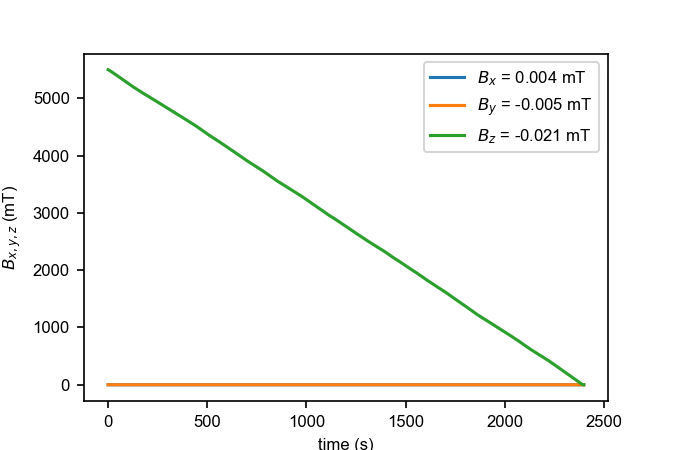

In [13]:
x_setpoint = 0 #E-3; # T
y_setpoint = 0 #E-3; # T
z_setpoint = 0 #E-3; # T

fig = plt.figure('set B');
fig.clear();
fpl = fig.add_subplot(1, 1, 1);

Bx, By, Bz = [], [], [];
eps = 1E-5; # T

ami_x.ramp_rate(0.001); # T/s
ami_y.ramp_rate(0.001); # T/s
ami_z.ramp_rate(0.0015); # T/s

ami_x.ramp_to(x_setpoint);
ami_y.ramp_to(y_setpoint);
ami_z.ramp_to(z_setpoint);

while np.abs(x_setpoint - ami_x.field()) > eps or np.abs(y_setpoint - ami_y.field()) > eps or np.abs(z_setpoint - ami_z.field()) > eps:
    
    Bx.append(ami_x.field());
    By.append(ami_y.field());
    Bz.append(ami_z.field());
    
    fpl.clear();
    fpl.plot(range(0, len(Bx)), np.array(Bx) * 1E3, range(0, len(By)), np.array(By)*1E3, range(0, len(Bz)), np.array(Bz)*1E3);
    fpl.legend(('$B_x$ = {} mT'.format(str(round(Bx[-1]*1E3, 3))), '$B_y$ = {} mT'.format(str(round(By[-1]*1E3, 3))), '$B_z$ = {} mT'.format(str(round(Bz[-1]*1E3, 3)))));
    plt.xlabel('time (s)');
    plt.ylabel('$B_{x,y,z}$ (mT)');
    fig.canvas.draw();
    
    time.sleep(1);

In [89]:
ami_x.ramp_to(0)
ami_y.ramp_to(0)
ami_z.ramp_to(0)

## Setters, getters, gate ramp functions

In [20]:
gate_ramp_stepsize = 1e-3  #[V]
gate_ramp_delay = 0.01  #[s]

def ramp(param, target, step_size, delay): 
    current_value = param()
    step_size *= np.sign(target - current_value)
    if abs(step_size) < 1E-10: 
        return 
    
    steps = np.arange(current_value, target, step_size)
    for step in steps: 
        param(step)
        time.sleep(delay)
    
    param(target)
    
def set_mdac_in_safemode(nchan=64):
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    sr1.amplitude(0)
    sr1.sine_outdc(0)
    
    print('setting mdac in safe mode')
    
    for ch in mdac.channels[:nchan]:
        ramp(ch.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

    # Note: we do this in separate loops because we want to be sure that
    # no currents are running anywhere before switching the relays
    for ch in mdac.channels[:nchan]:
        ch.dac_output('open')
        ch.bus('open')
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
        #ch.divider('off')
    print('Done')

def chs_safe(*channels):
    sr1.amplitude(0)
    sr1.sine_outdc(0)   
    print('setting mdac in safe mode')
    for ch in channels:
        ramp(ch.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
        ch.dac_output('open')
        ch.bus('open')
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
    print('Done')

In [21]:
@getter(('raw_voltage', 'V'), ('current', 'A')) #,('V_meas', 'V')
def measure_dc_only(gain=1e7):
    time.sleep(0.03) # * key.NPLC()) 
    key_raw = key1.volt()
    #key_raw2 = key2.volt()
    current = -key_raw/gain
    #V_meas = key2.volt()
    return key_raw, current  #, V_meas

In [22]:
gate_ramp_stepsize = 1e-3  #[V]
gate_ramp_delay = 0.01  #[s]


def mdac_gate_voltage_raw(voltage): 
    ramp(gate.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
    
mdac_gate_voltage = setter(("mdac_gate_voltage", "V"))(mdac_gate_voltage_raw)


bias_ramp_stepsize = 1e-3  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.01  #[s]

@setter(("mdac_bias_voltage", "V"))
def mdac_bias_voltage(voltage): 
    voltage *= 790
    ramp(source.voltage, voltage, bias_ramp_stepsize, bias_ramp_delay)

@setter(("lockin_dc", "V"))
def lockin_dc(voltage): 
    voltage *= 100
    ramp(sr1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

@setter(("yoko2_voltage", "V"))
def yoko2_voltage(voltage): 
    #voltage *= 790
    ramp(yoko2.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

@setter(("time_sweep", "a.u."))
def time_sweep(a): 
    time.sleep(0.001)
    
@setter(("datapoint", "a.u."))
def datapoint(a): 
    time.sleep(0)    
    
@setter(("field_sweep", "T"))
def field_sweep(a):
    time.sleep(0.001);

In [39]:
@setter(("temperature", "K"))
def set_temperature(a):
    h.blocking_t(a);

In [23]:
def initialize(s,g):
    ramp(s.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
    ramp(g.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
    s.smc('close')
    s.dac_output('close')
    #d.gnd('close')
    g.dac_output('close')
    g.smc('close')

# Actual measurements

## Defining soure, drain, gate channels

In [43]:
sources = [mdac.ch58]
gate = mdac.ch09

In [71]:
source = mdac.ch58
gate = mdac.ch18

## Qcodes upgrade tester

In [42]:
mdac_gate_voltage(1)

{'mdac_gate_voltage': 1}

In [43]:
sr1.sine_outdc(0)

In [44]:
vals = np.linspace(1,-1,401)
gate_points = np.append(vals,vals[::-1])

In [45]:
def setup():
    #set_mdac_in_safemode()
#     initialize(source, gate)
    #mdac.ch57.voltage(0)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(1e-3)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #sr.amplitude(5e-5)     #bias AC voltage
    #sr.frequency(7)
    #sr1.phase(168.5)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_y.field(0)

In [46]:
def cleanup(): 
    print('closing the measurement.')
#     set_mdac_in_safemode()
    #sr.amplitude(0)
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)


In [47]:
data_extractor = do_experiment(
    "Qcodes_upgrade_test",
    nest(
        #sweep(ami_x.field, np.linspace(0, 0.4, 64)),
        sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
#         sweep(yoko2_voltage, np.linspace(0, -10, 11)),
        #sweep(mdac_gate_voltage, np.linspace(0, -3, 201)),
#         sweep(mdac_gate_voltage, np.linspace(4, 5, 101)),
        #sweep(mdac_bias_voltage, np.linspace(10e-3,-10e-3,101)),  
        measure(measure_dc_only)
    ),
    setup,
    cleanup,
    live_plot=True
)

Starting experimental run with id: 2
closing the measurement.


## DC + lockin, V bias

In [30]:
initialize(source,gate)

In [121]:
set_mdac_in_safemode()
sr1.amplitude(0)
lockin_dc(0)

setting mdac in safe mode
Done


{'lockin_dc': 0}

In [127]:
chs_safe(gate)
initialize(source,gate)
mdac_gate_voltage(1)

setting mdac in safe mode
Done


{'mdac_gate_voltage': 1}

In [1]:
2/301

0.006644518272425249

In [245]:
def setup():
    #set_mdac_in_safemode()
    #chs_safe(gate)
    #initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_gate_voltage(-0.2)
#    lockin_dc(10e-3)
    #gate.voltage(0.8)
#     key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    lockin_dc(0)
    sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(3)

def cleanup(): 
    #pass
    sr1.amplitude(0)
    lockin_dc(0)
    #chs_safe(gate)
    #set_mdac_in_safemode()   
    mdac_gate_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e6, Rseries=15e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    if np.abs(np.abs(sr1.sine_outdc())-0.05) < 80e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

gate_values = np.linspace(-0.2, -1, 101)
#gate_values = np.linspace(0, -0.75, 3)
# gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q0169_1400b_CoolDown_RF_QPC_BiasVsGate_5.5T",
    nest(
        #sweep(ami_z.field, np.linspace(5, 0, 51)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
#         sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        sweep(mdac_gate_voltage, gate_values),
        sweep(lockin_dc, np.linspace(-15e-3, 15e-3, 101)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure(measure_acdc)
    ),
    setup,
    cleanup,
    live_plot=True
)

Starting experimental run with id: 68


In [118]:
def setup():
    #set_mdac_in_safemode()
#     chs_safe(gate)
#     initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
#     mdac_gate_voltage(0)
#    lockin_dc(10e-3)
    #gate.voltage(0.8)
#     key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
#     lockin_dc(10e-3)
    lockin_dc(0.45e-3)
    sr1.amplitude(1e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)
    print('Setup done.')

def cleanup(): 
    #pass
    sr1.amplitude(0)
    lockin_dc(0)
#     chs_safe(gate)
    #set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    print('Cleanup done.');
    
@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'), 
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), 
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e7, Rseries=23.4e3, adder_atten=1e-2):
    time.sleep(0.1)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
#     if np.abs(np.abs(sr1.sine_outdc())-0.05) < 80e-3: # make this range larger than distance btw two points
#        print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
#        time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

#gate_values = np.linspace(0, -0.75, 101)
# gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q0191_C24D1_bias_Yfield_Temp=25mK",
    nest(
        sweep(ami_x.field, np.linspace(0, 0.05, 101)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        #sweep(mdac_gate_voltage, gate_values),
        sweep(lockin_dc, np.linspace(0.45e-3, -0.45e-3, 51)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure(measure_acdc)
    ),
    setup,
    cleanup, 
    live_plot=True
)

Setup done.
Starting experimental run with id: 84
Cleanup done.


In [116]:
ami_x.field(0)

In [ ]:
def setup():
    set_mdac_in_safemode()
    initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_gate_voltage(0.24)
#    lockin_dc(10e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    sr1.phase(180)
    #sr1.time_constant(.1)
    ami_x.field(-1)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)

def cleanup(): 
    #pass
    sr1.amplitude(0)
    sr1.sine_outdc(0)
    set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
# Basically converts callable function to generator
def get_next(val):
    while 1:
        yield val();

# Generate linspace points until val() is outside of window        
def smart_linspace(start, stop, step, val, lowlim, highlim, eps): 
    linspace = np.linspace(start, stop, step)
    for value in linspace:

        if val() < (lowlim - eps) or val() > (highlim + eps):
            break

        yield value

# Sweep the field as long as val() is within the window
def field_window(magnet, lowlim, highlim, eps_multi = 0.01, init_to_closest_lim = True):

    val = magnet.field;

    # To correct for overshoot since the last window sweep of size eps, sweep field back to either
    # lowlim or highlim, whichever the current field value is closest to, then begin
    if init_to_closest_lim:

        lowlim_diff = np.abs(val() - lowlim);
        highlim_diff = np.abs(val() - highlim);

        if lowlim_diff < highlim_diff:
            initlim = lowlim;
            finlim = highlim;
        else:
            initlim = highlim;
            finlim = lowlim;

        eps = finlim * eps_multi * (-1 if finlim == lowlim else 1);

        print('Initializing (blocking) field to {} T ...'.format(initlim))
        magnet.field(initlim);
        print('Sweeping (non-blocking) field to {} T ...'.format(finlim))
        magnet.ramp_to(finlim + eps);

    for field_val in get_next(val):
        if np.abs(field_val - finlim) < np.abs(eps):
                break

        yield field_val

@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V')) #, ('B_x', 'T')
def measure_acdc(gain=1e6, Rseries=18.4e3, adder_atten=1e-2):
    time.sleep(0.01)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        #time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac #, B_x
    return result

#gate_values = np.linspace(1, -0.3, 101)
#gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q169_B15B13_AB_120mK_largeBsweep_Vg=0.24_checkSetField",
    nest(       
        sweep(ami_x.field, np.linspace(-1, 1, 13010)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        #sweep(field_sweep, field_window(ami_x, -1, 1)),
        #sweep(mdac_gate_voltage, gate_values),
        #sweep(lockin_dc, np.linspace(15e-3, -15e-3, 201)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure(measure_acdc)
    ),
    [(setup, ())],
    [(cleanup, ())], 
    live_plot=True
)

In [207]:
def setup():
    set_mdac_in_safemode()
    initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_gate_voltage(0)
    lockin_dc(0)
#     lockin_dc(20e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)

def cleanup(): 
    #pass
    sr1.amplitude(0)
    sr1.sine_outdc(0)
    set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e6, Rseries=23.4e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

#gate_values = np.linspace(1, -0.5, 201)
#gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q0169_1400b_D25D26_QPC_0field_gate_bias",
    nest(
#         sweep(ami_z.field, np.linspace(5.5, 0, 56)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
        #sweep(sr1.sine_outdc, np.linspace(15e-3, -15e-3, 100)),
        sweep(mdac_gate_voltage, np.linspace(-0.25, -0.9, 101)),
        sweep(lockin_dc, np.linspace(20e-3, -20e-3, 201)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure(measure_acdc)
    ),
    [(setup, ())],
    [(cleanup, ())], 
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=None #[{"gate": 0, "Conductance (G_0)": 3}]
)

setting mdac in safe mode
Done
Starting experimental run with id: 402
setting mdac in safe mode
Done
Completed measurement. Database path: Q0169_1400b_D25D26_QPC_0field_gate_bias/2


In [40]:
print(ami_x.field())
print(ami_y.field())
print(ami_z.field())

-1.000005
-3.3e-06
-4.6e-06


## Dot DC measurements

### Pinchoffs

In [ ]:
initialize(source,gate)
# initialize(source,mdac.ch17)

In [25]:
set_mdac_in_safemode()
sr1.amplitude(0)
lockin_dc(0)

setting mdac in safe mode
Done


{'lockin_dc': 0}

In [82]:
ami_x.ramp_to(0)

In [104]:
source = mdac.ch58
TG1_ch = mdac.ch10;
PG_ch = mdac.ch18;
TG2_ch = mdac.ch26;
#PG2_ch = mdac.ch33;

initialize(source, TG1_ch)
initialize(source, PG_ch)
initialize(source, TG2_ch)


In [259]:
def setup():
    #set_mdac_in_safemode()
    #chs_safe(gate)
    #initialize(source, TG1_ch)
    #initialize(source, PG_ch)
    #initialize(source, TG2_ch)
    #initialize(source, PG2_ch)
    #mdac_TG1(-0.8)
    #mdac_TG2(-0.8)
    mdac_PG(0.5)
#     mdac_PG2(0.5)
    mdac_TG1(0.5)
    mdac_TG2(0.5)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #mdac_bias_voltage(5e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
#     lockin_dc(10e-3)
    lockin_dc(0)
    sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)

def cleanup(): 
    #pass
    sr1.amplitude(0)
    lockin_dc(0)
    #chs_safe(gate)
    #set_mdac_in_safemode()   
    print('!!! GATES NOT ZEROED !!!')
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
@setter(("mdac_TG1", "V"))
def mdac_TG1(voltage):
    ramp(TG1_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
    
@setter(("mdac_TG2", "V"))
def mdac_TG2(voltage):
    ramp(TG2_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

@setter(("mdac_PG", "V"))
def mdac_PG(voltage):
    ramp(PG_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

@setter(("mdac_PG2", "V"))
def mdac_PG2(voltage):
    ramp(PG2_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
       
@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e6, Rseries=18e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 1e-3: # make this range larger than distance btw two points
#         print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        #time.sleep(3)
#         print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

#gate_values = np.linspace(1, 0, 301)
# gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q0169_1400b_RF_cooldown_QD2_pinchoff",
    nest(
        #sweep(ami_z.field, np.linspace(0, 5.5, 55)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        sweep(mdac_TG2, np.linspace(0.5,-1,51)),
        #sweep(mdac_PG, np.linspace(0.5,0.49,501)),
        #sweep(lockin_dc, np.linspace(450e-6, -450e-6, 101)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure(measure_acdc)
    ),
    setup,
    cleanup,
    live_plot=True
)

Starting experimental run with id: 75
!!! GATES NOT ZEROED !!!


### Dual gate sweep

In [86]:
TG1_ch = mdac.ch09;
PG_ch = mdac.ch17;
TG2_ch = mdac.ch25;

def setup():
    set_mdac_in_safemode()
    #chs_safe(gate)
    initialize(source, TG1_ch)
    initialize(source, TG2_ch)
    initialize(source, PG_ch)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_PG(0.5)
    mdac_TG1(-0.8)
    mdac_TG2(-0.8)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #lockin_dc(10e-3)
    lockin_dc(0)
    sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)

def cleanup(): 
    #pass
    sr1.amplitude(0)
    lockin_dc(0)
    #chs_safe(gate)
    set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)

@setter(("mdac_TG1", "V"))
def mdac_TG1(voltage):
    ramp(TG1_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
    
@setter(("mdac_TG2", "V"))
def mdac_TG2(voltage):
    ramp(TG2_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

@setter(("mdac_PG", "V"))
def mdac_PG(voltage):
    ramp(PG_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
    
@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'), 
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e6, Rseries=13.4e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        #time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

gate_values_TG1 = np.linspace(-0.8, 0.2, 101)
gate_values_TG2 = np.linspace(-0.8, 0.2, 101)
# gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q0169_1400b_B21C18_0bias_TG1vsTG2_PG=0.5V",
    nest(
        #sweep(ami_z.field, np.linspace(0, 5.5, 55)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
#         sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        sweep(mdac_TG1, gate_values_TG1),
        sweep(mdac_TG2, gate_values_TG2),
        #sweep(lockin_dc, np.linspace(15e-3, -15e-3, 201)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure(measure_acdc)
    ),
    [(setup, ())],
    [(cleanup, ())], 
    return_format=["data_set_path", "dataset"], 
    live_plot_axes= None
)

setting mdac in safe mode
Done
Starting experimental run with id: 24
setting mdac in safe mode
Done
Completed measurement. Database path: Q0169_1400b_B21C18_0bias_TG1vsTG2_PG=0.5V/0


### Bias vs. PG

In [115]:
TG1_ch = mdac.ch17;
PG_ch = mdac.ch09;
TG2_ch = mdac.ch25;

def setup():
    set_mdac_in_safemode()
    #chs_safe(gate)
    initialize(source, TG1_ch)
    initialize(source, TG2_ch)
    initialize(source, PG_ch)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_PG(0.49)
    mdac_TG1(-0.8)
    mdac_TG2(-0.8)
    mdac_TG1(-0.37)
    mdac_TG2(-0.6)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
#     lockin_dc(3e-3)
    lockin_dc(0)
    sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)

def cleanup(): 
    #pass
    sr1.amplitude(0)
    lockin_dc(0)
    #chs_safe(gate)
    set_mdac_in_safemode()
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)

@setter(("mdac_TG1", "V"))
def mdac_TG1(voltage):
    ramp(TG1_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
    
@setter(("mdac_TG2", "V"))
def mdac_TG2(voltage):
    ramp(TG2_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

@setter(("mdac_PG", "V"))
def mdac_PG(voltage):
    ramp(PG_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
    
@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e6, Rseries=23.4e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        #time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

gate_values_PG = np.linspace(0.49, 0.494, 51)
dc_values = np.linspace(375e-6, -375e-6, 51)
# gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q0169_1400b_B21C18_bias_vs._PG_TG1=-0.37_TG2=-0.6_cryoamp_ON_SignalHound_ON",
    nest(
        #sweep(ami_z.field, np.linspace(0, 5.5, 55)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
#         sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        sweep(mdac_PG, gate_values_PG),
        sweep(lockin_dc, dc_values),
        #sweep(lockin_dc, np.linspace(15e-3, -15e-3, 201)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure(measure_acdc)
    ),
    [(setup, ())],
    [(cleanup, ())], 
    live_plot=True
)

setting mdac in safe mode
Done
Starting experimental run with id: 40
setting mdac in safe mode
Done
Completed measurement. Database path: Q0169_1400b_B21C18_bias_vs._PG_TG1=-0.37_TG2=-0.6_cryoamp_ON_SignalHound_ON/0


## Measure while ramping $B$

In [44]:
initialize(source, gate)

In [65]:
mdac_gate_voltage(0.2)  

{'mdac_gate_voltage': 0.2}

<IPython.core.display.Javascript object>


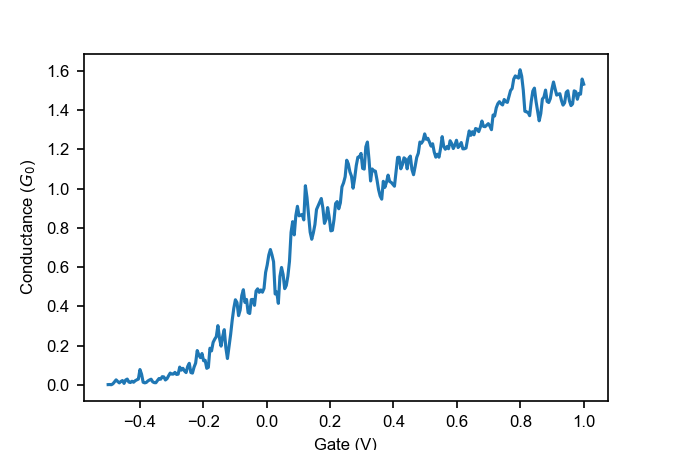

setting mdac in safe mode
Done
Starting experimental run with id: 2
setting mdac in safe mode
Done


Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "d:\code\qcodes\qcodes\dataset\data_set.py", line 132, in run
    self._loop()
  File "d:\code\qcodes\qcodes\dataset\data_set.py", line 163, in _loop
    self._call_callback_on_queue_data()
  File "d:\code\qcodes\qcodes\dataset\data_set.py", line 146, in _call_callback_on_queue_data
    self.callback(result_list, self._data_set_len, self.state)
  File "D:\Code\v2_dataset_tools\experiments\realtime_monitors.py", line 54, in __call__
    xnew, ynew = [r[i] for i in [self.x_index, self.y_index]]
  File "D:\Code\v2_dataset_tools\experiments\realtime_monitors.py", line 54, in <listcomp>
    xnew, ynew = [r[i] for i in [self.x_index, self.y_index]]
IndexError: list index out of range



IndexError: list index out of range

In [46]:

def setup():
    set_mdac_in_safemode()
    initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_gate_voltage(1)
    lockin_dc(0e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    sr1.time_constant(.1)
    #ami_x.field(0)
    time.sleep(1)
    ami_x.ramp_rate(0.001) # T/s

    # Field setting and ramping should now be done automagically in the field_window function
    #ami_x.ramp_to(0) # unit: T. non-blocking
#     ami_x.ramp_to(0.4) # unit: T. non-blocking

def cleanup(): 
    #pass
    ami_x.field(ami_x.field()) # stops the non-blocking field ramp
    sr1.amplitude(0)
    lockin_dc(0)
    set_mdac_in_safemode()
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_z.field(0)

# Basically converts callable function to generator
def get_next(val):
    while 1:
        yield val();

# Generate linspace points until val() is outside of window        
def smart_linspace(start, stop, step, val, lowlim, highlim, eps): 
    linspace = np.linspace(start, stop, step)
    for value in linspace:

        if val() < (lowlim - eps) or val() > (highlim + eps):
            break

        yield value

# Sweep the field as long as val() is within the window
def field_window(magnet, lowlim, highlim, eps_multi = 0.01, init_to_closest_lim = True):

    val = magnet.field;

    # To correct for overshoot since the last window sweep of size eps, sweep field back to either
    # lowlim or highlim, whichever the current field value is closest to, then begin
    if init_to_closest_lim:

        lowlim_diff = np.abs(val() - lowlim);
        highlim_diff = np.abs(val() - highlim);

        if lowlim_diff < highlim_diff:
            initlim = lowlim;
            finlim = highlim;
        else:
            initlim = highlim;
            finlim = lowlim;

        eps = finlim * eps_multi * (-1 if finlim == lowlim else 1);

        print('Initializing (blocking) field to {} T ...'.format(initlim))
        magnet.field(initlim);
        print('Sweeping (non-blocking) field to {} T ...'.format(finlim))
        magnet.ramp_to(finlim + eps);

    for field_val in get_next(val):
        if np.abs(field_val - finlim) < np.abs(eps):
                break

        yield field_val

@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'), ('B_x', 'T'))
def measure_acdc(gain=1e6, Rseries=13.4e3, adder_atten=1e-2):
    time.sleep(0.02) 
    B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        #time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906.4/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac, B_x
    return result

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q169_A5A10_pinchoff_0mVbias",
    nest(       
        #sweep(ami_x.field, np.linspace(0, 1, 5001)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, smart_linspace(0, 1, 4200, ami_x.field, 0.06, 0.16, 0.0025)),
        #sweep(field_sweep, field_window(ami_x, -1, 1)),
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        sweep(mdac_gate_voltage, np.linspace(1,-0.5, 300)),
        #sweep(lockin_dc, np.linspace(10e-3, -10e-3, 51)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure(measure_acdc)
    ),
    [(setup, ())],
    [(cleanup, ())],
)

## Zig zag sweeping $B$ at various gates

3.46150108335e-06


<IPython.core.display.Javascript object>


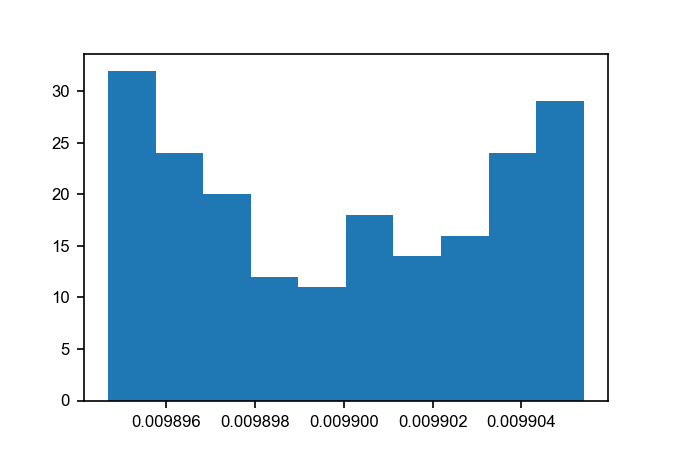

(array([ 32.,  24.,  20.,  12.,  11.,  18.,  14.,  16.,  24.,  29.]),
 array([ 0.0098947 ,  0.00989577,  0.00989684,  0.00989791,  0.00989898,
         0.00990005,  0.00990112,  0.00990219,  0.00990326,  0.00990433,
         0.0099054 ]),
 <a list of 10 Patch objects>)

In [119]:
s = np.empty(200)
for i in range(200):
    s[i] = ami_x.field()
print(s.std())
plt.figure('field std')
plt.hist(s)

In [34]:
set_mdac_in_safemode()
sr1.amplitude(0)
sr1.sine_outdc(0)
sr2.amplitude(0)
sr2.sine_outdc(0)
#ivvi.set_dacs_zero()
key1.write('ABOR')
key2.write('ABOR')
ami_x.ramp_to(0)

setting mdac in safe mode
Done


timeout: ('timed out', "asking 'COIL?' to <AMI430: AMI430_x>")

In [55]:
#set_mdac_in_safemode()
initialize(source, gate)
sr1.amplitude(2e-3)
sr1.phase(0)

# Setup DMM for continuous measurements
key1.write('CONF:VOLT:DC 1,1E-6'); # config 1 V range and 1 uV resolution
key1.write('SENS:VOLT:DC:NPLC 1'); # set NPLC, will adjust resolution ^ as per device manual
key1.write('TRIG:DEL MIN'); # MIN = 1 us, minimum delay after trigger received as meas started
key1.write('TRIG:SOUR IMM'); # trigger signal always present, immediate triggering
key1.write('TRIG:COUN INF'); # take continuous measurements
key1.write('INIT'); # start

for sweep_counter, gate_step in enumerate(np.array([[x]*2 for x in [0.29, 0.31, 0.32]]).reshape(-1).tolist()):
    def setup():
        #set_mdac_in_safemode()
        #initialize(source, gate)
        #ami_z.field(5.5)
        #mdac.ch49.voltage(-3.5)
        #mdac.ch57.dac_output('close')
        #mdac.ch57.smc('close')
        #key1.NPLC(1)
        #source.voltage(0.8) 
        #mdac_bias_voltage(5e-3)
        mdac_gate_voltage(gate_step)
        #lockin_dc(10e-3)
        #gate.voltage(0.8)
        #key2.NPLC(1)
        #ivvi.dac1(0)
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
        #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
        #sr1.frequency(117)     # adder HPF cutoff is 15Hz
        #sr1.phase(0)
        sr1.time_constant(.1)
        #ami_x.field(0)
        ami_x.ramp_rate(0.0005)
        time.sleep(1)
        #if sweep_counter % 2 == 0: # first time (counter==0)
        #    ami_x.ramp_to(1) # non-blocking
        #else:
        #    ami_x.ramp_to(0)

    def cleanup(): 
        pass
        #sr1.amplitude(0)
        #sr1.sine_outdc(0)
        #set_mdac_in_safemode()
        #mdac_voltage(0)
        #mdac.ch57.dac_output('open')
        #mdac.ch57.smc('open')
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #ivvi.dac1(0)    
        #yoko2.voltage(0)
        #ami_x.field(0)
        #ami_z.field(0)
    
    # Basically converts callable function to generator
    def get_next(val):
        while 1:
            yield val();

    # Generate linspace points until val() is outside of window        
    def smart_linspace(start, stop, step, val, lowlim, highlim, eps): 
        linspace = np.linspace(start, stop, step)
        for value in linspace:

            if val() < (lowlim - eps) or val() > (highlim + eps):
                break

            yield value

    # Sweep the field as long as val() is within the window
    def field_window(magnet, lowlim, highlim, eps = 1E-5, init_to_closest_lim = True):

        val = magnet.field;
        
        lowlim_diff = np.abs(val() - lowlim);
        highlim_diff = np.abs(val() - highlim);

        if lowlim_diff < highlim_diff:
            initlim = lowlim;
            finlim = highlim;
        else:
            initlim = highlim;
            finlim = lowlim;

        #eps = finlim * eps_multi * (-1 if finlim == lowlim else 1);
        #eps = 1e-5
        
        # To correct for overshoot since the last window sweep of size eps, sweep field back to either
        # lowlim or highlim, whichever the current field value is closest to, then begin
        if init_to_closest_lim:           

            print('Initializing (blocking) field to {} T ...'.format(initlim))
            magnet.field(initlim);
            
        print('Sweeping (non-blocking) field to {} T ...'.format(finlim))
        magnet.ramp_to(finlim + eps);

        for field_val in get_next(val):
            if np.abs(field_val - finlim) < np.abs(eps):
                    break

            yield field_val
    
    @getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
            ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
            ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'), ('B_x', 'T'))
    def measure_acdc(gain=1e6, Rseries=18.4e3, adder_atten=1e-2):
        time.sleep(0.04) 
        B_x = ami_x.field()
        key_raw = float(key1.ask('DATA:LAST?').split(' ')[0]) # 8.36 ms ± 166 µs per loop
        current_dc = -key_raw/gain
        #V_meas = key2.volt()
        #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
            #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
            #time.sleep(3)
            #print(sr1.X())
        Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
        #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
        #L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
        #L1R     = sr1.R()
        #L1Y     = sr1.Y()
        L1X, L1Y, L1P = sr1.get_values('X', 'Y', 'P')
        L1R = (L1X**2 + L1Y**2)**.5 # Using native Python syntax is 300x faster than numpy 23.3 ns ± 0.0317 ns per loop
        # the above lines (excluding time.sleep) take at least 75ms to execute. 
        current_ac = L1X/gain    
        g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
        #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
        result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac, B_x
        return result

    result = do_experiment(
    #     "NIS-Thermometer/SIM_10k",
        "Q169_B15B13_ring_AB_stability_test_"+str(gate_step)+"gate_0bias_0T_to_1T_temp_1100mK_sweep"+str(sweep_counter),#gate="+str(0.4 + sweep_counter*0.02),
        nest(       
            #sweep(ami_x.field, np.linspace(0, 1, 5001)),
            #sweep(sr1.frequency, np.linspace(80,130,41)),
            #sweep(gate.voltage, np.linspace(0, -3, 61)),
            #sweep(time_sweep, np.linspace(0, 1, 4200)),  # make sure this takes longer than the field ramp
            #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
            sweep(field_sweep, field_window(ami_x, 0, 1)),
            #sweep(mdac_gate_voltage, gate_values),
            #sweep(lockin_dc, np.linspace(10e-3, -10e-3, 51)), # real voltage applied onto device
            #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
            #sweep(mdac_gate_voltage, gate_points),
            measure(measure_acdc)
        ),
        [(setup, ())],
        [(cleanup, ())], 
        live_plot=False
    )
                       
    time.sleep(10)

#set_mdac_in_safemode()
sr1.amplitude(0)
#sr1.sine_outdc(0)
key1.write('ABOR'); # Stop Keysight measurements

Starting experimental run with id: 144
Initializing (blocking) field to 0 T ...
Sweeping (non-blocking) field to 1 T ...
Completed measurement. Database path: Q169_B15B13_ring_AB_stability_test_0.29gate_0bias_0T_to_1T_temp_1100mK_sweep0/0
Starting experimental run with id: 145
Initializing (blocking) field to 1 T ...
Sweeping (non-blocking) field to 0 T ...
Completed measurement. Database path: Q169_B15B13_ring_AB_stability_test_0.29gate_0bias_0T_to_1T_temp_1100mK_sweep1/0
Starting experimental run with id: 146
Initializing (blocking) field to 0 T ...
Sweeping (non-blocking) field to 1 T ...
Completed measurement. Database path: Q169_B15B13_ring_AB_stability_test_0.31gate_0bias_0T_to_1T_temp_1100mK_sweep2/0
Starting experimental run with id: 147
Initializing (blocking) field to 1 T ...
Sweeping (non-blocking) field to 0 T ...
Completed measurement. Database path: Q169_B15B13_ring_AB_stability_test_0.31gate_0bias_0T_to_1T_temp_1100mK_sweep3/0
Starting experimental run with id: 148
Initi

### Dual wire mobility, gate and field sweep

In [41]:
#set_mdac_in_safemode()
initialize(source, gate)
sr1.amplitude(2e-3)
sr1.phase(0)
sr2.amplitude(2e-3)
sr2.phase(0)

# Setup DMM for continuous measurements
key1.write('CONF:VOLT:DC 1,1E-6'); # config 1 V range and 1 uV resolution
key1.write('SENS:VOLT:DC:NPLC 1'); # set NPLC, will adjust resolution ^ as per device manual
key1.write('TRIG:DEL MIN'); # MIN = 1 us, minimum delay after trigger received as meas started
key1.write('TRIG:SOUR IMM'); # trigger signal always present, immediate triggering
key1.write('TRIG:COUN INF'); # take continuous measurements
key1.write('INIT'); # start

key2.write('CONF:VOLT:DC 1,1E-6'); # config 1 V range and 1 uV resolution
key2.write('SENS:VOLT:DC:NPLC 1'); # set NPLC, will adjust resolution ^ as per device manual
key2.write('TRIG:DEL MIN'); # MIN = 1 us, minimum delay after trigger received as meas started
key2.write('TRIG:SOUR IMM'); # trigger signal always present, immediate triggering
key2.write('TRIG:COUN INF'); # take continuous measurements
key2.write('INIT'); # start

for sweep_counter, gate_step in enumerate([round(x, 1) for x in np.linspace(-0.3, 1.5, 19).tolist()]):
    def setup():
        #set_mdac_in_safemode()
        #initialize(source, gate)
        #ami_z.field(5.5)
        #mdac.ch49.voltage(-3.5)
        #mdac.ch57.dac_output('close')
        #mdac.ch57.smc('close')
        #key1.NPLC(1)
        #source.voltage(0.8) 
        #mdac_bias_voltage(5e-3)
        mdac_gate_voltage(gate_step)
        #lockin_dc(10e-3)
        #gate.voltage(0.8)
        #key2.NPLC(1)
        #ivvi.dac1(0)
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
        #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
        #sr1.frequency(117)     # adder HPF cutoff is 15Hz
        #sr1.phase(0)
        sr1.time_constant(.1)
        sr2.time_constant(.1)
        #ami_x.field(0)
        ami_x.ramp_rate(0.0005)
        time.sleep(1)
        #if sweep_counter % 2 == 0: # first time (counter==0)
        #    ami_x.ramp_to(1) # non-blocking
        #else:
        #    ami_x.ramp_to(0)

    def cleanup(): 
        pass
        #sr1.amplitude(0)
        #sr1.sine_outdc(0)
        #set_mdac_in_safemode()
        #mdac_voltage(0)
        #mdac.ch57.dac_output('open')
        #mdac.ch57.smc('open')
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #ivvi.dac1(0)    
        #yoko2.voltage(0)
        #ami_x.field(0)
        #ami_z.field(0)

    # Basically converts callable function to generator
    def get_next(val):
        while 1:
            yield val();

    # Generate linspace points until val() is outside of window        
    def smart_linspace(start, stop, step, val, lowlim, highlim, eps): 
        linspace = np.linspace(start, stop, step)
        for value in linspace:

            if val() < (lowlim - eps) or val() > (highlim + eps):
                break

            yield value

    # Sweep the field as long as val() is within the window
    def field_window(magnet, lowlim, highlim, eps = 1E-5, init_to_closest_lim = True):

        val = magnet.field;

        lowlim_diff = np.abs(val() - lowlim);
        highlim_diff = np.abs(val() - highlim);

        if lowlim_diff < highlim_diff:
            initlim = lowlim;
            finlim = highlim;
        else:
            initlim = highlim;
            finlim = lowlim;

        #eps = finlim * eps_multi * (-1 if finlim == lowlim else 1);
        #eps = 1e-5

        # To correct for overshoot since the last window sweep of size eps, sweep field back to either
        # lowlim or highlim, whichever the current field value is closest to, then begin
        if init_to_closest_lim:           

            print('Initializing (blocking) field to {} T ...'.format(initlim))
            magnet.field(initlim);

        print('Sweeping (non-blocking) field to {} T ...'.format(finlim))
        magnet.ramp_to(finlim + eps);

        for field_val in get_next(val):
            if np.abs(field_val - finlim) < np.abs(eps):
                    break

            yield field_val

    @getter(('current_1', 'A'), ('current_2', 'A'), 
            ('raw_voltage_dc_1', 'V'), ('raw_voltage_dc_2', 'V'),
            ('conductance_1', '2e^2/h'), ('conductance_2', '2e^2/h'),
            ('Lockin1_X', 'V'), ('Lockin2_X', 'V'),
            ('Lockin1_Y', 'V'), ('Lockin2_Y', 'V'), 
            ('Lockin1_R', 'V'), ('Lockin2_R', 'V'), 
            ('Lockin1_phase', 'deg'), ('Lockin2_phase', 'deg'), 
            ('Lockin1_excitation', 'V'), ('Lockin2_excitation', 'V'), 
            ('B_x', 'T'))
    def measure_acdc(gain=1e6, Rseries_1=13.4E3, Rseries_2=18.4E3, adder_atten=1e-2):
        time.sleep(0.04) 
        B_x = ami_x.field()
        key1_raw = float(key1.ask('DATA:LAST?').split(' ')[0]); # 8.36 ms ± 166 µs per loop
        key2_raw = float(key1.ask('DATA:LAST?').split(' ')[0]);
        current_dc_1 = -key1_raw / gain;
        current_dc_2 = -key2_raw / gain;
        #V_meas = key2.volt()
        #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
            #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
            #time.sleep(3)
            #print(sr1.X())
        Vac_1     = adder_atten * sr1.amplitude()  #*np.sqrt(2)
        Vac_2     = adder_atten * sr2.amplitude()  #*np.sqrt(2)
        #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
        #L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
        #L1R     = sr1.R()
        #L1Y     = sr1.Y()
        L1X, L1Y, L1P = sr1.get_values('X', 'Y', 'P')
        L2X, L2Y, L2P = sr2.get_values('X', 'Y', 'P')
        L1R = (L1X**2 + L1Y**2)**.5; # Using native Python syntax is 300x faster than numpy 23.3 ns ± 0.0317 ns per loop
        L2R = (L2X**2 + L2Y**2)**.5;
        # the above lines (excluding time.sleep) take at least 75ms to execute. 
        current_ac_1 = L1X / gain;
        current_ac_2 = L2X / gain;
        g_1       = 12906 / (Vac_1 / current_ac_1 - Rseries_1) #[2e^2/h]
        g_2       = 12906 / (Vac_2 / current_ac_2 - Rseries_2) #[2e^2/h]
        #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
        result  = current_dc_1, current_dc_2, key1_raw, key2_raw, g_1, g_2, L1X, L1Y, L1R, L1P, L2X, L2Y, L2R, L2P, Vac_1, Vac_2, B_x
        return result

    result = do_experiment(
    #     "NIS-Thermometer/SIM_10k",
        "Q169_dual_wire_(1)_page5_(2)_page6_"+str(gate_step)+"gate_0bias_-0.5T_to_0.5T_sweep"+str(sweep_counter),
        nest(       
            #sweep(ami_x.field, np.linspace(0, 1, 5001)),
            #sweep(sr1.frequency, np.linspace(80,130,41)),
            #sweep(gate.voltage, np.linspace(0, -3, 61)),
            #sweep(time_sweep, np.linspace(0, 1, 4200)),  # make sure this takes longer than the field ramp
            #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
            sweep(field_sweep, field_window(ami_x, -0.5, 0.5)),
            #sweep(mdac_gate_voltage, gate_values),
            #sweep(lockin_dc, np.linspace(10e-3, -10e-3, 51)), # real voltage applied onto device
            #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
            #sweep(mdac_gate_voltage, gate_points),
            measure(measure_acdc)
        ),
        [(setup, ())],
        [(cleanup, ())], 
        live_plot=False
    )

set_mdac_in_safemode();
sr1.amplitude(0);
sr2.amplitude(0);
key1.write('ABOR');
key2.write('ABOR');
ami_x.ramp_to(0);

Starting experimental run with id: 194
Initializing (blocking) field to 0.5 T ...
Sweeping (non-blocking) field to -0.5 T ...
Completed measurement. Database path: Q169_dual_wire_(1)_page5_(2)_page6_-0.3gate_0bias_-0.5T_to_0.5T_sweep0/0
Starting experimental run with id: 195
Initializing (blocking) field to -0.5 T ...
Sweeping (non-blocking) field to 0.5 T ...
Completed measurement. Database path: Q169_dual_wire_(1)_page5_(2)_page6_-0.2gate_0bias_-0.5T_to_0.5T_sweep1/0
Starting experimental run with id: 196
Initializing (blocking) field to 0.5 T ...
Sweeping (non-blocking) field to -0.5 T ...
Completed measurement. Database path: Q169_dual_wire_(1)_page5_(2)_page6_-0.1gate_0bias_-0.5T_to_0.5T_sweep2/0
Starting experimental run with id: 197
Initializing (blocking) field to -0.5 T ...
Sweeping (non-blocking) field to 0.5 T ...
Completed measurement. Database path: Q169_dual_wire_(1)_page5_(2)_page6_0.0gate_0bias_-0.5T_to_0.5T_sweep3/0
Starting experimental run with id: 198
Initializing (

## 3D B-field sweeps

### Playground
![title](240px-3D_Spherical.svg.png)

In [30]:
# Block/non-block toggle
ami_3d.block_during_ramp(not ami_3d.block_during_ramp())
ami_3d.block_during_ramp()

False

In [31]:
# (r, theta, phi)
ami_3d.spherical((0.01, 0, 90))

In [32]:
ami_3d.spherical_measured()

[6.8533860244407652e-05, 42.904903311190452, -87.174389660950197]

In [33]:
ami_3d.cartesian_measured()

[8.5e-06, -3.34e-05, 0.0004194]

### Sweep over spherical coord

In [34]:
def setup():
    #set_mdac_in_safemode()
#     chs_safe(gate)
#     initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
#     mdac_gate_voltage(0)
#    lockin_dc(10e-3)
    #gate.voltage(0.8)
#     key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
#     lockin_dc(10e-3)
    lockin_dc(0.45e-3)
    sr1.amplitude(1e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    ami_3d.spherical((0.1, 90, 90))
    time.sleep(1)
    print('Setup done.')

def cleanup(): 
    #pass
    sr1.amplitude(0)
    lockin_dc(0)
#     chs_safe(gate)
    #set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    print('Cleanup done.');
    
@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'), 
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), 
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e8, Rseries=23.4e3, adder_atten=1e-2):
    time.sleep(0.1)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
#     if np.abs(np.abs(sr1.sine_outdc())-0.05) < 80e-3: # make this range larger than distance btw two points
#        print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
#        time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

#gate_values = np.linspace(0, -0.75, 101)
# gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q0191_C24D1_bias_field_phi",
    nest(
        #sweep(ami_x.field, np.linspace(0, 0.05, 101)),
        sweep(ami_3d.phi, np.linspace(0, 360, 101)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        #sweep(mdac_gate_voltage, gate_values),
        sweep(lockin_dc, np.linspace(0.45e-3, -0.45e-3, 2)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure(measure_acdc)
    ),
    setup,
    cleanup, 
    live_plot=True
)

Setup done.
Starting experimental run with id: 15201
Cleanup done.


In [211]:
new_experiment('measurement', 'sample')

measurement#Q0191#1@D:\OneDrive\BF3\Data\experiments_2018-10_2.db
-----------------------------------------------------------------

### B field stability statistics

In [231]:
def setup():
    #set_mdac_in_safemode()
#     chs_safe(gate)
#     initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
#     mdac_gate_voltage(0)
#    lockin_dc(10e-3)
    #gate.voltage(0.8)
#     key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
#     lockin_dc(10e-3)
    lockin_dc(0.45e-3)
    sr1.amplitude(1e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    ami_3d.spherical((0.01, 45, 45))
    time.sleep(1)
    print('Setup done.')

def cleanup(): 
    #pass
    sr1.amplitude(0)
    lockin_dc(0)
#     chs_safe(gate)
    #set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    print('Cleanup done.');
    
# @getter(('meas_time_Bxyz', 's'), ('meas_time_Brtp', 's'), ('B_x', 'T'), ('B_y', 'T'), ('B_z', 'T'), ('B_r', 'T'), ('B_theta', 'T'), ('B_phi', 'T'))
@getter(('meas_time_Bx', 's'), ('B_x', 'T'))
def measure_acdc(gain=1e7, Rseries=23.4e3, adder_atten=1e-2):
    #time.sleep(0.1)
    #B_x = ami_x.field()
    #key_raw = key1.volt()
    #current_dc = -key_raw/gain
    
#     time0_cart = time.time();
#     B_x, B_y, B_z = ami_3d.cartesian_measured()
#     time1_cart = time.time();
#     B_r, B_theta, B_phi = ami_3d.spherical_measured()
#     time1_sph = time.time();
#     dt_cart = time1_cart - time0_cart;
#     dt_sph = time1_sph - time1_cart;
    
    time0 = time.time();
    B_x = ami_3d.x_measured();
    dt = time.time() - time0;
    
    #V_meas = key2.volt()
#     if np.abs(np.abs(sr1.sine_outdc())-0.05) < 80e-3: # make this range larger than distance btw two points
#        print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
#        time.sleep(3)
        #print(sr1.X())
    #Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    #L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    #L1R     = sr1.R()
    #L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    #L1X     = sr1.X()
    #current_ac = L1X/gain    
    #g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
#     result  = dt_cart, dt_sph, B_x, B_y, B_z, B_r, B_theta, B_phi
    result = dt, B_x
    return result

#gate_values = np.linspace(0, -0.75, 101)
# gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "B-field_stability_test_x_only_rho=0.01,theta=45,phi=45",
    nest(
        #sweep(ami_x.field, np.linspace(0, 0.05, 101)),
        #sweep(ami_3d.phi, np.linspace(0, 360, 101)),
        #sweep(ami_3d.theta, np.linspace(0, 180, 51)),
        sweep(datapoint, np.linspace(0, 1600, 1601)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        #sweep(mdac_gate_voltage, gate_values),
        #sweep(lockin_dc, np.linspace(0.45e-3, -0.45e-3, 201)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure(measure_acdc)
    ),
    setup,
    cleanup, 
    live_plot=True
)

Setup done.
Starting experimental run with id: 95
Cleanup done.


## Temperature dependence with Lakeshore

In [40]:
h.setpoint()

0.0

In [45]:
def setup():
    #set_mdac_in_safemode()
#     chs_safe(gate)
#     initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
#     mdac_gate_voltage(0)
#    lockin_dc(10e-3)
    #gate.voltage(0.8)
#     key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
#     lockin_dc(10e-3)
    lockin_dc(0.45e-3)
    sr1.amplitude(1e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    ami_3d.spherical((0, 0, 0))
    time.sleep(1)
    print('Setup done.')

def cleanup(): 
    #pass
    sr1.amplitude(0)
    lockin_dc(0)
#     chs_safe(gate)
    #set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    h.blocking_t(0);
    print('Cleanup done.');
    
@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'), 
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), 
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e8, Rseries=23.4e3, adder_atten=1e-2):
    time.sleep(0.1)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
#     if np.abs(np.abs(sr1.sine_outdc())-0.05) < 80e-3: # make this range larger than distance btw two points
#        print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
#        time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

#gate_values = np.linspace(0, -0.75, 101)
# gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "temp_bias_0field/Q0191_C24D1_",
    nest(
        #sweep(ami_x.field, np.linspace(0, 0.05, 101)),
        sweep(set_temperature, np.linspace(20e-3, 1.2, 101)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        #sweep(mdac_gate_voltage, gate_values),
        sweep(lockin_dc, np.linspace(0.45e-3, -0.45e-3, 101)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure(measure_acdc)
    ),
    setup,
    cleanup, 
    live_plot=True
)

Setup done.
Starting experimental run with id: 6


KeyboardInterrupt: 

## Current bias measurements

In [55]:
sr1.frequency()

7.31

In [79]:
set_mdac_in_safemode()
sr1.amplitude(0)
lockin_dc(0)
ivvi.set_dacs_zero()

setting mdac in safe mode
Done


In [167]:
source = mdac.ch58
gate = mdac.ch09

In [44]:
initialize(source, gate)
mdac_gate_voltage(1)

{'mdac_gate_voltage': 1}

In [61]:
sr1.phase(0)
sr2.phase(0)

In [73]:
ami_x.field()

-1.0000044

In [75]:
sr1.X()

-6.2980648181e-06

In [80]:
def setup():
    set_mdac_in_safemode()
    initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_gate_voltage(0.3)
    #lockin_dc(10e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    sr1.amplitude(1)     # 1e-2 RF attenuator, then 1e-2 IVVI attenuator, then 1e-5 A/V I-source, so 1V -> 1nA
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(19.31) 
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(1)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)

def cleanup(): 
    #pass
    sr1.amplitude(0)
    #sr1.sine_outdc(0)
    set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
@getter(('dc_voltage1', 'V'), ('dc_voltage2', 'V'),
        ('raw_voltage_DMM1', 'V'), ('raw_voltage_DMM2', 'V'),
        ('R_xx', 'h/2e^2'), ('R_xy', 'Ohm'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'),
        ('Lockin2_X', 'V'), ('Lockin2_Y', 'V'), ('Lockin2_R', 'V'), ('Lockin2_phase', 'deg'),
        ('Lockin1_excitation', 'A'))
def measure_i_bias(gain1=1e3, gain2=1e3, source_atten=1e-9):
    time.sleep(0.05)
    #B_x = ami_x.field()
    key1_raw = key1.volt()
    voltage1_dc = -key1_raw/100  # the dc gain is always 100 when V-meas is set to ac coupling
    key2_raw = key2.volt()
    voltage2_dc = -key2_raw/100
    #V_meas = key2.volt()
    Iac     = source_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P, L2P     = sr1.P(), sr2.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R, L2R     = sr1.R(), sr2.R()
    L1Y, L2Y     = sr1.Y(), sr2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X, L2X     = sr1.X(), sr2.X()
    voltage1_ac, voltage2_ac = L1X/gain1, L2X/gain2
    g       = voltage1_ac/Iac / 12906.4 #[h/2e^2], using lockin1 for R_xx and lockin2 for R_xy
    R_hall = voltage2_ac / Iac
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = voltage1_dc, voltage2_dc, key1_raw, key2_raw, g, R_hall, L1X, L1Y, L1R, L1P, L2X, L2Y, L2R, L2P, Iac
    return result

#gate_values = np.linspace(0, -0.1, 51)
#gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q169_1400b_A14A11_Ibias_gate_field_Vg=1V...2V",
    nest(       
        sweep(ami_x.field, np.linspace(-1, 1, 201)),
        #sweep(sr1.frequency, np.linspace(1,141,141)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        sweep(mdac_gate_voltage, np.linspace(1, 2, 201)),
        #sweep(lockin_dc, np.linspace(15e-3, -15e-3, 201)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure(measure_i_bias)
    ),
    [(setup, ())],
    [(cleanup, ())], 
    live_plot=True
)

setting mdac in safe mode
Done
Starting experimental run with id: 20
setting mdac in safe mode
Done
Completed measurement. Database path: Q169_1400b_A14A11_Ibias_gate_field_Vg=1V...2V/1


In [ ]:
# field ramp
set_mdac_in_safemode()
initialize(source, gate)

for mdgv in np.linspace(0, 1.5, 31):

    def setup():
        #ami_z.field(5.5)
        #mdac.ch49.voltage(-3.5)
        #mdac.ch57.dac_output('close')
        #mdac.ch57.smc('close')
        #key1.NPLC(1)
        #source.voltage(0.8) 
        #mdac_bias_voltage(5e-3)
        mdac_gate_voltage(mdgv)
        #lockin_dc(10e-3)
        #gate.voltage(0.8)
        #key2.NPLC(1)
        #ivvi.dac1(0)
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        sr1.amplitude(1)     # 1e-2 RF attenuator, then 1e-2 IVVI attenuator, then 1e-5 A/V I-source, so 1V -> 1nA
        #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
        #sr1.frequency(31.296) 
        #sr1.phase(0)
        #sr1.time_constant(.1)
        #ami_x.field(0)
        #ami_x.ramp_to(-0.2)
        time.sleep(1)

    def cleanup(): 
        pass
        #sr1.amplitude(0)
        #sr1.sine_outdc(0)
        #set_mdac_in_safemode()   
        #mdac_voltage(0)
        #mdac.ch57.dac_output('open')
        #mdac.ch57.smc('open')
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #ivvi.dac1(0)    
        #yoko2.voltage(0)
        #ami_x.field(0)
        #ami_z.field(0)


    # Basically converts callable function to generator
    def get_next(val):
        while 1:
            yield val();

    # Generate linspace points until val() is outside of window        
    def smart_linspace(start, stop, step, val, lowlim, highlim, eps): 
        linspace = np.linspace(start, stop, step)
        for value in linspace:

            if val() < (lowlim - eps) or val() > (highlim + eps):
                break

            yield value

    # Sweep the field as long as val() is within the window
    def field_window(magnet, lowlim, highlim, eps_multi = 0.01, init_to_closest_lim = True):

        val = magnet.field;

        # To correct for overshoot since the last window sweep of size eps, sweep field back to either
        # lowlim or highlim, whichever the current field value is closest to, then begin
        if init_to_closest_lim:

            lowlim_diff = np.abs(val() - lowlim);
            highlim_diff = np.abs(val() - highlim);

            if lowlim_diff < highlim_diff:
                initlim = lowlim;
                finlim = highlim;
            else:
                initlim = highlim;
                finlim = lowlim;

            eps = finlim * eps_multi * (-1 if finlim == lowlim else 1);

            print('Initializing (blocking) field to {} T ...'.format(initlim))
            magnet.field(initlim);
            print('Sweeping (non-blocking) field to {} T ...'.format(finlim))
            magnet.ramp_to(finlim + eps);

        for field_val in get_next(val):
            if np.abs(field_val - finlim) < np.abs(eps):
                    break

            yield field_val

    @getter(('dc_voltage1', 'V'), ('dc_voltage2', 'V'),
            ('raw_voltage_DMM1', 'V'), ('raw_voltage_DMM2', 'V'),
            ('R_xx', 'h/2e^2'), ('R_xy', 'Ohm'),
            ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'),
            ('Lockin2_X', 'V'), ('Lockin2_Y', 'V'), ('Lockin2_R', 'V'), ('Lockin2_phase', 'deg'),
            ('Lockin1_excitation', 'A'),
            ('B_x', 'T'))
    def measure_i_bias(gain1=1e3, gain2=1e3, source_atten=1e-9):
        time.sleep(0.1)
        B_x = ami_x.field()
        key1_raw = key1.volt()
        voltage1_dc = -key1_raw/100  # the dc gain is always 100 when V-meas is set to ac coupling
        key2_raw = key2.volt()
        voltage2_dc = -key2_raw/100
        #V_meas = key2.volt()
        Iac     = source_atten*sr1.amplitude()  #*np.sqrt(2)
        #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
        L1P, L2P     = sr1.P(), sr2.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
        L1R, L2R     = sr1.R(), sr2.R()
        L1Y, L2Y     = sr1.Y(), sr2.Y()
        # the above lines (excluding time.sleep) take at least 75ms to execute. 
        L1X, L2X     = sr1.X(), sr2.X()
        voltage1_ac, voltage2_ac = L1X/gain1, L2X/gain2
        g       = voltage1_ac/Iac / 12906.4 #[h/2e^2], using lockin1 for R_xx and lockin2 for R_xy
        R_hall = voltage2_ac / Iac
        #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
        result  = voltage1_dc, voltage2_dc, key1_raw, key2_raw, g, R_hall, L1X, L1Y, L1R, L1P, L2X, L2Y, L2R, L2P, Iac, B_x
        return result

    result = do_experiment(
    #     "NIS-Thermometer/SIM_10k",
        "Q169_B2B5_Ibias_field_ramp_vs_gate_Vg={:.2f}V".format(mdgv),
        nest(       
            #sweep(ami_x.field, np.linspace(0, 1, 5001)),
            #sweep(sr1.frequency, np.linspace(80,130,41)),
            #sweep(gate.voltage, np.linspace(0, -3, 61)),
            #sweep(mdac_gate_voltage, np.linspace(0, 1, 101)),
            #sweep(time_sweep, smart_linspace(0, 1, 4200, ami_x.field, 0.06, 0.16, 0.0025)),
            sweep(field_sweep, field_window(ami_x, -1, 1)),
            #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
            #sweep(lockin_dc, np.linspace(10e-3, -10e-3, 51)), # real voltage applied onto device
            #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
            #sweep(mdac_gate_voltage, gate_points),
            measure(measure_i_bias)
        ),
        [(setup, ())],
        [(cleanup, ())], 
        live_plot=False
    )

sr1.amplitude(0)
mdac_gate_voltage(0.3)

setting mdac in safe mode
Done
Starting experimental run with id: 115
Initializing (blocking) field to -1 T ...
Sweeping (non-blocking) field to 1 T ...
Completed measurement. Database path: Q169_B2B5_Ibias_field_ramp_vs_gate_Vg=0.00V/0
Starting experimental run with id: 116
Initializing (blocking) field to 1 T ...
Sweeping (non-blocking) field to -1 T ...
Completed measurement. Database path: Q169_B2B5_Ibias_field_ramp_vs_gate_Vg=0.05V/0
Starting experimental run with id: 117
Initializing (blocking) field to -1 T ...
Sweeping (non-blocking) field to 1 T ...
Completed measurement. Database path: Q169_B2B5_Ibias_field_ramp_vs_gate_Vg=0.10V/0
Starting experimental run with id: 118
Initializing (blocking) field to 1 T ...
Sweeping (non-blocking) field to -1 T ...
Completed measurement. Database path: Q169_B2B5_Ibias_field_ramp_vs_gate_Vg=0.15V/0
Starting experimental run with id: 119
Initializing (blocking) field to -1 T ...
Sweeping (non-blocking) field to 1 T ...
Completed measurement. 

## field_window quickfix test
Workaround for generator running out of yields and stopping the measurement code after only one iteration

Will store fresh field_window generator as first element in list called field_win

This element is then updated with a new instance of the field_window generator upon completion of iteration,
allowing for a fresh sweep to start the next iteration

In [34]:
# field ramp

def setup():
    #set_mdac_in_safemode()
    #initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    #key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    #mdac_gate_voltage(0)
    #lockin_dc(10e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #sr1.amplitude(1)     # 1e-2 RF attenuator, then 1e-2 IVVI attenuator, then 1e-5 A/V I-source, so 1V -> 1nA
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
#     sr1.frequency(31.296) 
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)

def cleanup(): 
    #pass
    #sr1.amplitude(0)
    lockin_dc(0)
    set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    

# Basically converts callable function to generator
def get_next(val):
    while 1:
        yield val();

# Generate linspace points until val() is outside of window        
def smart_linspace(start, stop, step, val, lowlim, highlim, eps): 
    linspace = np.linspace(start, stop, step)
    for value in linspace:

        if val() < (lowlim - eps) or val() > (highlim + eps):
            break

        yield value

# Sweep the field as long as val() is within the window
def field_window(magnet, lowlim, highlim, eps_multi = 0.01, init_to_closest_lim = True):

    val = magnet.field;

    # To correct for overshoot since the last window sweep of size eps, sweep field back to either
    # lowlim or highlim, whichever the current field value is closest to, then begin
    if init_to_closest_lim:

        lowlim_diff = np.abs(val() - lowlim);
        highlim_diff = np.abs(val() - highlim);

        if lowlim_diff < highlim_diff:
            initlim = lowlim;
            finlim = highlim;
        else:
            initlim = highlim;
            finlim = lowlim;

        eps = finlim * eps_multi * (-1 if finlim == lowlim else 1);

        print('Initializing (blocking) field to {} T ...'.format(initlim))
        magnet.field(initlim);
        print('Sweeping (non-blocking) field to {} T ...'.format(finlim))
        magnet.ramp_to(finlim + eps);

    for field_val in get_next(val):
        if np.abs(field_val - finlim) < np.abs(eps):
                break

        yield field_val

def renew_generator(gen, store, args):
    store[0] = gen(*args);
        
@getter(('dc_voltage1', 'V'), ('dc_voltage2', 'V'),
        ('raw_voltage_DMM1', 'V'), ('raw_voltage_DMM2', 'V'),
        ('R_xx', 'h/2e^2'), ('R_xy', 'Ohm'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'),
        ('Lockin2_X', 'V'), ('Lockin2_Y', 'V'), ('Lockin2_R', 'V'), ('Lockin2_phase', 'deg'),
        ('Lockin1_excitation', 'A'), 
        ('B_x', 'T'))
def measure_i_bias(gain1=1e3, gain2=1e3, source_atten=1e-9):
    time.sleep(0.05)
    B_x = ami_x.field()
    key1_raw = key1.volt()
    voltage1_dc = -key1_raw/100  # the dc gain is always 100 when V-meas is set to ac coupling
    key2_raw = key2.volt()
    voltage2_dc = -key2_raw/100
    #V_meas = key2.volt()
    Iac     = source_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P, L2P     = sr1.P(), sr2.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R, L2R     = sr1.R(), sr2.R()
    L1Y, L2Y     = sr1.Y(), sr2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X, L2X     = sr1.X(), sr2.X()
    voltage1_ac, voltage2_ac = L1X/gain1, L2X/gain2
    g       = voltage1_ac/Iac / 12906.4 #[h/2e^2], using lockin1 for R_xx and lockin2 for R_xy
    R_hall = voltage2_ac / Iac
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = voltage1_dc, voltage2_dc, key1_raw, key2_raw, g, R_hall, L1X, L1Y, L1R, L1P, L2X, L2Y, L2R, L2P, Iac, B_x
    return result

# Workaround for generator running out of yields and stopping the measurement code after only one iteration
# Will store fresh field_window generator as first element in list called field_win
# This element is then updated with a new instance of the field_window generator upon completion of iteration,
# allowing for a fresh sweep to start the next iteration
field_window_args = [ami_x, -0.95, -1];
field_win = [None];
renew_generator(field_window, field_win, field_window_args);

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q169_field_ramp_regeneration_test",
    nest(       
        #sweep(ami_x.field, np.linspace(0, 1, 5001)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(mdac_gate_voltage, np.linspace(0, 1, 101)),
        sweep(time_sweep, np.linspace(0,1,5)),
        sweep(field_sweep, field_win[0]),
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        #sweep(lockin_dc, np.linspace(10e-3, -10e-3, 51)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        renew_generator(field_window, field_win, field_window_args),
        measure(measure_i_bias)
    ),
    [(setup, ())],
    [(cleanup, ())], 
    live_plot=True
)

ValueError: ('Do not know how to wrap instance of ', <class 'NoneType'>)

# Miscellaneous/debugging 

In [ ]:
ramp(sr1.sine_outdc, 0, bias_ramp_stepsize, bias_ramp_delay)

In [54]:
%%timeit
B_x = ami_x.field()

108 ms ± 3.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [86]:
initialize(source,gate)

In [87]:
mdac_gate_voltage(0.3)

{'mdac_gate_voltage': 0.29999999999999999}

In [22]:
mdac_gate_voltage(0)

NameError: name 'mdac_gate_voltage' is not defined

In [61]:
sr2.amplitude(2e-3);

In [ ]:
r1 = mdac.ch58
r2 = mdac.ch62

In [ ]:
r2.dac_output('close')
r2.smc('close')

In [ ]:
r2.voltage(1e-3)

In [ ]:
r1.voltage(0)
r1.dac_output('open')
r1.smc('open')

In [ ]:
mdac.ch58.dac_output('close')
mdac.ch58.smc('close')

In [ ]:
mdac.ch58.divider()

In [77]:
initialize(source, gate)

In [ ]:
ami_z.ramp_to(5)

In [114]:
%%timeit
#B_x = ami_x.field()
key1_raw, key2_raw = key1.volt(), key2.volt()
voltage1_dc, voltage2_dc = -key1_raw/100, -key2_raw/100
Iac     = 1e-2*sr1.amplitude()  #*np.sqrt(2)
L1X, L1Y, L1P = sr1.get_values('X', 'Y', 'P')
L2X, L2Y, L2P = sr2.get_values('X', 'Y', 'P')
L1R, L2R = np.sqrt(np.power(L1X,2)+np.power(L1Y,2)), np.sqrt(np.power(L2X,2)+np.power(L2Y,2))
voltage1_ac, voltage2_ac = L1X/100, L2X/100
g       = voltage1_ac / 12906.4 #[h/2e^2], using lockin1 for R_xx and lockin2 for R_xy
R_hall = voltage2_ac 

VisaIOError: ('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', "asking 'READ?' to <Keysight_34465A: key1>", 'getting key1_volt')

In [13]:
%%timeit
# sr1.ask('SNAPD?')
# sr2.ask('SNAPD?')

# testing on 28/08/2018: this takes 35ms to execute
L1X, L1Y, L1P = sr1.get_values('X', 'Y', 'P')
L2X, L2Y, L2P = sr2.get_values('X', 'Y', 'P')
L1R, L2R = np.sqrt(np.power(L1X,2)+np.power(L1Y,2)), np.sqrt(np.power(L2X,2)+np.power(L2Y,2))

# testing on 28/08/2018: this takes 95ms to execute
# L1P, L2P     = sr1.P(), sr2.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
# L1R, L2R     = sr1.R(), sr2.R()
# L1Y, L2Y     = sr1.Y(), sr2.Y()
# # the above lines (excluding time.sleep) take at least 75ms to execute. 
# L1X, L2X     = sr1.X(), sr2.X()

34.7 ms ± 627 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [113]:
sr1.ask('CDSP? 2')

'8'

In [71]:
sr1.input_range()

1

In [1]:
%%timeit
#key2v = key2.volt()
key1v = key1.volt()

NameError: name 'key1' is not defined

In [125]:
gate.voltage()

0.5000042

In [ ]:
key1v = key1.volt

In [20]:
%%timeit
key1_raw, key2_raw = key1.volt(), key2.volt()

155 ms ± 8.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [133]:
mdac_gate_voltage(0)

{'mdac_gate_voltage': 0}

In [115]:
%%timeit
key1.get_idn()
key2.get_idn()

51 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Keysight continuous measurement

<IPython.core.display.Javascript object>


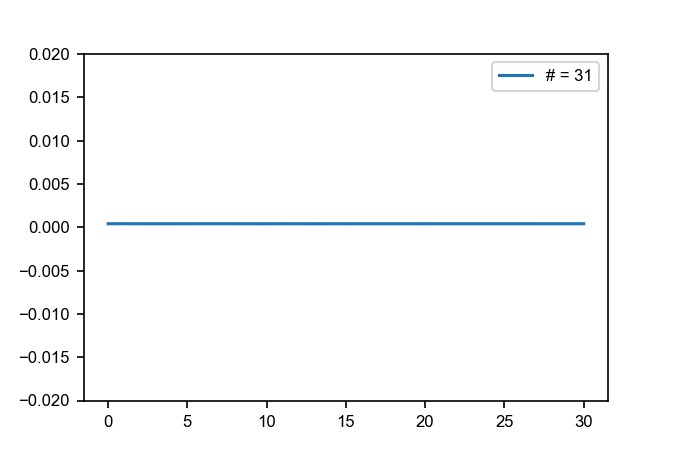

KeyboardInterrupt: 

In [66]:
#%%timeit

# Setup DMM for continuous measurements
key1.write('CONF:VOLT:DC 0.1,1E-6'); # config 100 mV range
key1.write('SENS:VOLT:DC:NPLC 1'); # set NPLC, capture rate seems 2x faster when also setting resolution ^
key1.write('TRIG:DEL MIN'); # MIN = 1 us, minimum delay after trigger received as meas started
key1.write('TRIG:SOUR IMM'); # trigger signal always present, immediate triggering
key1.write('TRIG:COUN INF'); # do not stop measuring once the immediate trigger is hit

key1.write('INIT'); # start
time.sleep(1); # allow it time to setup and measure a few first points

fig = plt.figure('key');
fpl = fig.add_subplot(1, 1, 1);

while True:
    
    key1_data = key1.ask('R?'); # get all logged data
    key1_data = key1_data[2 + int(key1_data[1]):]; # remove header info
       
    key1_volts = [float(x) for x in key1_data.split(',')]; # convert to floating point list
    
    fpl.clear();
    fpl.plot(range(len(key1_volts)), key1_volts);
    plt.ylim([-20E-3, 20E-3]);
    plt.legend(['# = ' + str(len(key1_volts))]);
    fig.canvas.draw();
    
    time.sleep(0.5);

In [74]:
# Performance test
%timeit float(key1.ask('DATA:LAST?').split(' ')[0])

8.36 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [90]:
%timeit np.sqrt(np.power(3.3478, 2) + np.power(3.38974, 2))
%timeit (3.3478**2 + 3.38974**2)**.5

6.26 µs ± 98.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
23.3 ns ± 0.0317 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [107]:
%%timeit
time.sleep(0.02) 
B_x = ami_x.field()
key_raw = float(key1.ask('DATA:LAST?').split(' ')[0]) # 8.36 ms ± 166 µs per loop
current_dc = -key_raw/1E6
#V_meas = key2.volt()
#if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
    #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
    #time.sleep(3)
    #print(sr1.X())
Vac     = 100*sr1.amplitude()  #*np.sqrt(2)
#SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
#L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
#L1R     = sr1.R()
#L1Y     = sr1.Y()
L1X, L1Y, L1P = sr1.get_values('X', 'Y', 'P')
L1R = (L1X**2 + L1Y**2)**.5 # Using native Python syntax is 300x faster than numpy 23.3 ns ± 0.0317 ns per loop
# the above lines (excluding time.sleep) take at least 75ms to execute. 
current_ac = L1X/1E6  
g       = 12906/(Vac/current_ac - 18.3E3) #[2e^2/h]
#result  = current_dc, key_raw, g, L1X, L1Y, V_meas
result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac, B_x

111 ms ± 4.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [106]:
%timeit L1X, L1Y, L1P = sr1.get_values('X', 'Y', 'P')

15.7 ms ± 60.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
def zigzag(minval, maxval, steps):
    call_count = 0;
    up = np.linspace(minval, maxval, steps);
    down = up[::-1];
    while True:
        yield up if call_count % 2 == 0 else down;
        call_count += 1;
        
a = zigzag(0, 1, 11);

In [ ]:
next(a)

## testing sweep

In [31]:
def setup():
    print('setting up')

def cleanup(): 
    print('cleaning up')
    
@setter(('awesomeness', 'coolio'))
def set_awesomeness(value):
    # dummy setter
    pass
    
@getter(('current', 'A'), ('conductance', '2e^2/h'))
def get_curr_and_conductance(gain=1e6, Rseries=18.4e3, adder_atten=1e-2):
    current_dc = np.random.rand() + 5
    g = np.random.rand() + 10
    time.sleep(0.5)  # this is needed for plottr/zmq to have enough time to send stuff
    return current_dc, g

result = do_experiment(
    "sweep_test/no_sample",
    nest(
        sweep(set_awesomeness, np.linspace(20e-3, -20e-3, 10)),
        measure(get_curr_and_conductance)
    ),
    setup,
    cleanup,
    live_plot=True
)

setting up
Starting experimental run with id: 4
cleaning up


# RF measurements

In [14]:
ramp_bb = bb.PulseAtoms.ramp

In [15]:
BroadBeanSequence.chan_map = {
    1 : ['awg_voltage', 'ro_trigger', None],
}
BroadBeanSequence.chan_settings[1]['Vpp'] = 1.0
BroadBeanSequence.chan_settings[1]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]
BroadBeanSequence.chan_settings[1]['marker_lo'] = [-0.3, -0.3, -0.3, -0.3]
BroadBeanSequence.sweep_wait = None

TriggeredReadoutSequence.chan_map = {
    1 : ['FILL.1', 'ro_trigger', None],
}

In [16]:
def awg_trigger_func(do_start):
    if do_start:
        station.awg.play()
    else:
        station.awg.stop()
        
for ctl in [raw_acq, avgdemod_acq, avgiq_acq]:
    ctl.trigger_func = awg_trigger_func

In [126]:
with alazar.syncing():
    alazar.clock_source('INTERNAL_CLOCK') #INTERNAL_CLOCK EXTERNAL_CLOCK_10MHz_REF
    alazar.sample_rate(int(0.8e9))
    alazar.clock_edge('CLOCK_EDGE_RISING')
    alazar.external_sample_rate(int(1e9))
    alazar.decimation(1)
    alazar.coupling1('DC')
    alazar.coupling2('DC')
    alazar.channel_range1(0.4)
    alazar.channel_range2(0.4)
    alazar.impedance1(50)
    alazar.impedance2(50)
    alazar.trigger_source1('EXTERNAL')
    alazar.trigger_level1(128 + 20)
    alazar.external_trigger_coupling('DC')
    alazar.external_trigger_range('ETR_2V5') #ETR_TTL
    alazar.trigger_delay(0)
    alazar.timeout_ticks(int(1e7))

d:\onedrive\bf3\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


## Software sweep

In [511]:
ami_z.field()

5.4999751

In [333]:
hetsrc.frequency(4.1e8)
hetsrc.IF(20e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-10)
hetsrc.LO.power(15)

In [85]:
ro_att.attenuation(10)

In [66]:
np.sqrt(1/(220e-9*1e-12))/2/np.pi/1e6

339.31947878728505

In [240]:
hetsrc.RF.off()
hetsrc.LO.off()

In [108]:
set_mdac_in_safemode()
initialize(source,gate)

setting mdac in safe mode
Done


In [24]:
ramped_gate_voltage_parameter = Parameter('ramped_gate_voltage', label='Gate voltage', unit='V',
                                set_cmd=mdac_gate_voltage_raw, get_cmd=None)

In [153]:
meas_lockin = Parameter('Lockin1_X', label='Lockin X', unit='V',
                       set_cmd=None, get_cmd=sr1.X)

In [99]:
def lockin_bias(voltage): 
    voltage *= 100
    ramp(sr1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

bias = Parameter('lockin_bias', label='Bias', unit='V',
                       set_cmd=lockin_bias, get_cmd=None)

In [18]:
def set_mdac_TG1(voltage):
    ramp(TG1_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

mdac_TG1_param = Parameter('TG1_voltage', label='TG1', unit='V',
                          set_cmd=set_mdac_TG1, get_cmd=None)

def set_mdac_TG2(voltage):
    ramp(TG2_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

mdac_TG2_param = Parameter('TG2_voltage', label='TG2', unit='V',
                          set_cmd=set_mdac_TG2, get_cmd=None)

def set_mdac_PG(voltage):
    ramp(PG_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

mdac_PG_param = Parameter('PG_voltage', label='PG', unit='V',
                          set_cmd=set_mdac_PG, get_cmd=None)


In [330]:
rf_frqs = np.linspace(350e6, 500e6, 301)
gatevals = np.linspace(0.5, -1.5, 51)   #np.array([0.5, 0, -0.2, -0.8]) #np.linspace(0.5, -1.5, 101)
biasvals = np.linspace(-15e-3, 15e-3, 101)
ro_att_vals = np.array([10, 15, 20, 25, 30, 35])

In [287]:
rf_frqs[140]

420000000.0

In [337]:
hetsrc.RF.on()
hetsrc.LO.on()

setup_awg = True
int_time = 10e-6
buffer_len = 10e-6

set_mdac_PG(-0.2)
set_mdac_TG1(0)
set_mdac_TG2(0.5)
### End User settings


### Setting up instruments

# set acquisition controller
acq = avgiq_acq
acq.trigger_func = None

# create new instance of sequence and detector
sequence = instools.create_inst(TriggeredReadoutSequence, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = instools.create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

# configure the sequence parameters
sequence.pre_trigger_delay(1e-6) # some delay at the beginning
sequence.trigger_len(100e-9) # short trigger for the alazar
sequence.seq_len(10e-6) # quick rep-rate is OK here
if setup_awg:
    sequence.setup(program_awg=True, start_awg=True) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)
    
# configure the Alazar detector
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(buffer_len) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=int(int_time/buffer_len), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

### Set up the measurement info
exp = select_experiment('Test', 'Q0169_QPC_2nd_cooldown') # select experiment (info for the database)

# need to make sure the sweep is correctly described in the beginning!
meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          mdac_TG2_param,
                          #ro_att.attenuation
                          #ramped_gate_voltage_parameter,
                          #hetsrc.frequency
                          #bias
                      ],
                      #soft_data_params=[meas_lockin],
                     )


# and finally, the measurement loop
meas.write_period = 2 # how often to write to the DB [s]
with meas.run() as datasaver:
    
    # this is to connect the database to the plottr.
    plot_subscriber = QcodesDatasetSubscriber(datasaver.dataset)
    datasaver.dataset.subscribe(plot_subscriber, state=[])
    

    #for att in ro_att_vals:
        #ro_att.attenuation(att)
        #time.sleep(0.01)
    for p in gatevals:
        #ramped_gate_voltage_parameter(p)
        mdac_TG2_param(p)
        #for f in rf_frqs:
            #hetsrc.frequency(f)
            #time.sleep(0.01)

        detector.acquisition() # this gets the data from the alazar
        datasaver.add_result(*meas.get_result()) # this adds all data to the datasaver.

#mdac_gate_voltage(0)
#bias(0)

hetsrc.RF.off()
hetsrc.LO.off()

No ro_gate defined in channel map. No readout gate pulse will be generated.
No src_gate defined in channel map. No src gate pulse will be generated.


Instrument sequence already exists.
Instrument detector already exists.
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 95


In [53]:
hetsrc.RF.off()
hetsrc.LO.off()

In [346]:
set_mdac_PG(0)
set_mdac_TG1(0)
set_mdac_TG2(0)

In [251]:
mdac_gate_voltage(0)
bias(0)

In [322]:
station.alazar.samples_per_record() / station.alazar.sample_rate() * 1e6

1.92

## Hard sweeps

In [37]:
fg.ch1.impedance(50)
fg.ch1.burst.source('MAN')
fg.ch1.ampl(2)
fg.ch1.offset(1)

fg.ch1.state('ON')
fg.ch1.burst.on('ON')

fg.ch1.burst.trigger()

In [26]:
class AWGGateRamp1D(BroadBeanSequence):
    
    trigger_delay = 100e-9
    alazar_trigger_len = 100e-9
    sweep_dims = ['voltages', ]

    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self.add_parameter('initial_delay', set_cmd=None, 
                           unit='s', initial_value=10e-6)
        self.add_parameter('step_len', set_cmd=None, 
                           unit='s', initial_value=10e-6)
        self.add_parameter('start_voltage', set_cmd=None,
                           unit='V', initial_value=0)
        self.add_parameter('stop_voltage', set_cmd=None,
                           unit='V', initial_value=1)
        self.add_parameter('voltage_points', set_cmd=None,
                           unit='', initial_value=11)
        self.add_parameter('ramp_down_time', set_cmd=None,
                           unit='s', initial_value=10e-6)
        
    def setup(self, **kw):
        vpts = np.linspace(self.start_voltage(), self.stop_voltage(), self.voltage_points())
        self.voltages(vpts)
        super().setup(**kw)
        
        
    def sequence(self):
        elem = bb.Element()
        bps = BluePrints(self.chan_map, sample_rate=self.sample_rate())
        
        cut_t = 0
        bps['ro_trigger'] = []
        bps['awg_voltage'].insertSegment(0, ramp_bb, (self.start_voltage(), self.start_voltage()), 
                                         dur=self.initial_delay(), name='voltage')        
        for i, v in enumerate(self.voltages()):
            bps['awg_voltage'].insertSegment(i+1, ramp_bb, (v, v), 
                                             dur=self.step_len(), name='voltage')
            bps['ro_trigger'].append((self.initial_delay() + self.step_len() * i + self.trigger_delay, 
                                      self.alazar_trigger_len))
            
        bps['awg_voltage'].insertSegment(-1, ramp_bb, (v, self.start_voltage()), 
                                         dur=self.ramp_down_time(), name='voltage')        

        for n, bp in bps():
            elem.addBluePrint(n, bp)
            
        seq = bb.Sequence()
        seq.name = 'v_ramp'
        seq.addElement(1, elem)
        
        return seq
        

In [65]:
def awg_trigger_func(do_start):
    if do_start:
        awg.force_triggerA()
        #fg.ch1.state('ON')
        #station.awg.play()
        #fg.ch1.burst.trigger()
#     else:
        #fg.ch1.state('OFF')
        #station.awg.stop()
#         fg.ch1.burst.trigger()
        
for ctl in [raw_acq, avgdemod_acq, avgiq_acq]:
    ctl.trigger_func = awg_trigger_func

In [63]:
AWGGateRamp1D.sweep_wait = 'first'

In [130]:
hetsrc.frequency(410e6)
hetsrc.IF(20e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-10)
hetsrc.LO.power(15)
ro_att.attenuation(10)

# set IQ acquisition controller
acq = avgiq_acq
acq.trigger_func = awg_trigger_func

sequence = instools.create_inst(AWGGateRamp1D, 'awg_ramp', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = instools.create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

sequence.alazar_trigger_len = 100e-8
sequence.sample_rate(0.1e9)
sequence.initial_delay(50e-6)
sequence.step_len(3e-6)
sequence.start_voltage(0) #x10 for attenuation
sequence.stop_voltage(-0.5)    #x10 for attenuation
sequence.voltage_points(301)
sequence.ramp_down_time(10e-6)
sequence.setup(start_awg=True)

# configure the Alazar detector
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.step_len() - 2e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=sequence.voltage_points(),
    buffers_per_acquisition=1, # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

Instrument awg_ramp already exists.
Instrument detector already exists.
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


In [95]:
rf_frqs = np.linspace(350e6, 500e6, 301)
gatevals = np.linspace(-0.2, -1, 101)   #np.array([0.5, 0, -0.2, -0.8]) #np.linspace(0.5, -1.5, 101)
biasvals = np.linspace(-15e-3, 15e-3, 101)
ro_att_vals = np.array([10, 15, 20, 25, 30, 35])

In [131]:
set_mdac_PG(-0.2)
set_mdac_TG1(0)
#set_mdac_TG2(-0.2)


exp = select_experiment('10us_IntTime_fast_gate', 'Q0169_QPC_2nd_cooldown') # select experiment (info for the database)

# need to make sure the sweep is correctly described in the beginning!
meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          #mdac_TG2_param,
                          #ro_att.attenuation
                          #ramped_gate_voltage_parameter,
                          #hetsrc.frequency
                          bias
                      ],
                      #soft_data_params=[meas_lockin],
                     )


# and finally, the measurement loop
meas.write_period = 2 # how often to write to the DB [s]
with meas.run() as datasaver:
    
    # this is to connect the database to the plottr.
    plot_subscriber = QcodesDatasetSubscriber(datasaver.dataset)
    datasaver.dataset.subscribe(plot_subscriber, state=[])
    

    #for att in ro_att_vals:
        #ro_att.attenuation(att)
        #time.sleep(0.01)
    for b in biasvals:
        #ramped_gate_voltage_parameter(p)
        #mdac_TG2_param(p)
        bias(b)
        #for f in rf_frqs:
            #hetsrc.frequency(f)
            #time.sleep(0.01)

        detector.acquisition() # this gets the data from the alazar
        datasaver.add_result(*meas.get_result()) # this adds all data to the datasaver.

#mdac_gate_voltage(0)
#bias(0)

hetsrc.RF.off()
hetsrc.LO.off()

Starting experimental run with id: 20


RuntimeError: ('error 579: ApiWaitTimeout: operation did not finish during timeout interval. Check your trigger. from function AlazarWaitAsyncBufferComplete with args: [2516, c_void_p(1318571343872), 10000]', 'getting avgiq_acq_acquisition', 'getting detector_acquisition')

## Scribbles

In [76]:
hetsrc.frequency(410e6)
hetsrc.IF(20e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-10)
hetsrc.LO.power(15)

# set IQ acquisition controller
acq = avgiq_acq
acq.trigger_func = awg_trigger_func

sequence = instools.create_inst(AWGGateRamp1D, 'awg_ramp', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = instools.create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

sequence.alazar_trigger_len = 100e-8
sequence.sample_rate(1e9)
sequence.initial_delay(100e-6)
sequence.step_len(25e-6)
sequence.start_voltage(-0.2)
sequence.stop_voltage(0.2)
sequence.voltage_points(10)
sequence.ramp_down_time(10e-6)
sequence.setup(start_awg=True)

# configure the Alazar detector
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.step_len() - 5e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=sequence.voltage_points(),
    buffers_per_acquisition=1, # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

Instrument awg_ramp already exists.
Instrument detector already exists.
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


In [87]:
gatevals = np.linspace(-0.2, -1.5, 11)

for p in gatevals:
    #ramped_gate_voltage_parameter(p)
    #print(p)
    time.sleep(5e-3)
    #for f in rf_frqs:
        #hetsrc.frequency(f)
        #time.sleep(0.01)
    awg.force_triggerA()
    #detector.acquisition() #

In [517]:
fg.ch1.burst.trigger()

In [133]:
set_mdac_in_safemode()

setting mdac in safe mode
Done


In [82]:
t0=time.time()
#set_mdac_TG2(0)
awg.force_triggerA()
time.sleep(5e-3)
awg.force_triggerA()
time.sleep(5e-3)
awg.force_triggerA()
time.sleep(5e-3)
t1=time.time()
print(t1-t0)

0.023513078689575195


In [42]:
awg.force_triggerA

In [ ]:
set_mdac_in_safemode()
source = mdac.ch58
TG1_ch = mdac.ch10;
PG_ch = mdac.ch18;
TG2_ch = mdac.ch26;
#PG2_ch = mdac.ch33;

initialize(source, TG1_ch)
initialize(source, PG_ch)
initialize(source, TG2_ch)

In [132]:
alazar.samples_per_record()/alazar.sample_rate()*1e6

1.12